In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Villanova62_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Villanova62_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [ ]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [ ]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Villanova62', ref_nodes) 
            np.save('results/info_ref_nodes_Villanova62', info_ref_nodes) 
        
    number_feature += 1

## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [6]:
ref_nodes = np.load('results/ref_nodes_Villanova62.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Villanova62.npy') 

## Visualize the ground truth clusters

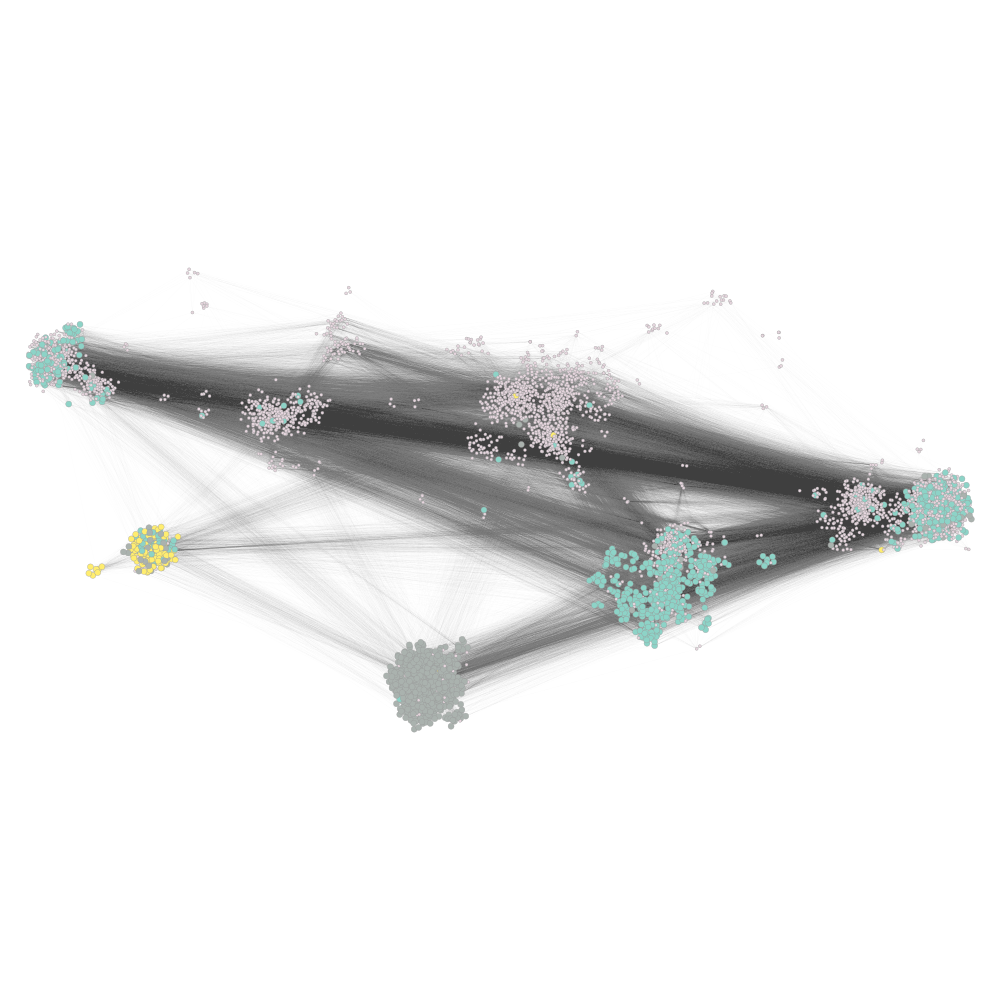

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14b7bb278, at 0x12dcb9a90>

In [7]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [53]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Villanova62', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Villanova62', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Villanova62', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Villanova62', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Villanova62', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Villanova62', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Villanova62', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Villanova62', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Villanova62', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Villanova62', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Villanova62', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Villanova62', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Villanova62', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Villanova62', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Villanova62', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Villanova62', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Villanova62', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Villanova62', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Villanova62', cuts_acl_ALL) 
    
    np.save('results/nodes_Villanova62', nodes)

100
outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.1936214708957825 f1score:  0.9269348728125565 precision:  0.8954339491111886 recall:  0.9607329842931938
outer: 0 number of node:  928  completed:  0.01  degree:  45.0
conductance:  0.21091254424587758 f1score:  0.9117105794694557 precision:  0.8768022101355435 recall:  0.949513836948392
outer: 0 number of node:  2365  completed:  0.02  degree:  74.0
conductance:  0.1895143190591615 f1score:  0.9292420425921686 precision:  0.9107639824041656 recall:  0.9484854151084517
outer: 0 number of node:  2776  completed:  0.03  degree:  36.0
conductance:  0.1966483372610631 f1score:  0.914909944477046 precision:  0.8845247446975648 recall:  0.9474569932685116
outer: 0 number of node:  3898  completed:  0.04  degree:  32.0
conductance:  0.18148820326678766 f1score:  0.9361760913612083 precision:  0.9224137931034483 recall:  0.950355272999252
outer: 0 number of node:  4909  completed:  0.05  degree:  54.0
conductan

outer: 0 number of node:  1718  completed:  0.45  degree:  39.0
conductance:  0.20185449358059915 f1score:  0.9288061336254108 precision:  0.9072753209700428 recall:  0.9513836948391923
outer: 0 number of node:  4746  completed:  0.46  degree:  18.0
conductance:  0.17730462481737838 f1score:  0.3960037369635265 precision:  0.24872464254065577 recall:  0.9709237097980553
outer: 0 number of node:  2530  completed:  0.47  degree:  41.0
conductance:  0.1826282712691117 f1score:  0.9338846730585724 precision:  0.9084961541861905 recall:  0.9607329842931938
outer: 0 number of node:  686  completed:  0.48  degree:  54.0
conductance:  0.2177800269905533 f1score:  0.9140652713728271 precision:  0.8693488529014844 recall:  0.9636312640239342
outer: 0 number of node:  2765  completed:  0.49  degree:  153.0
conductance:  0.2728902245954866 f1score:  0.10857174759301835 precision:  0.057401991037647246 recall:  1.0
outer: 0 number of node:  3594  completed:  0.5  degree:  47.0
conductance:  0.20055

outer: 0 number of node:  522  completed:  0.9  degree:  99.0
conductance:  0.20158484731349052 f1score:  0.8930811632769435 precision:  0.9080981832238114 recall:  0.8785527299925205
outer: 0 number of node:  3539  completed:  0.91  degree:  12.0
conductance:  0.18921449302499765 f1score:  0.9118211161528745 precision:  0.9124613800205973 recall:  0.9111817501869858
outer: 0 number of node:  1126  completed:  0.92  degree:  73.0
conductance:  0.18265800786609349 f1score:  0.9353183226224052 precision:  0.9251806457513949 recall:  0.9456806282722513
outer: 0 number of node:  4380  completed:  0.93  degree:  47.0
conductance:  0.19941051855945474 f1score:  0.9076230687143322 precision:  0.9008934328083265 recall:  0.9144540014958863
outer: 0 number of node:  2581  completed:  0.94  degree:  55.0
conductance:  0.21297429620563035 f1score:  0.9082858950031626 precision:  0.8788249694002448 recall:  0.9397905759162304
outer: 0 number of node:  4818  completed:  0.95  degree:  47.0
conducta

outer: 1 number of node:  1549  completed:  0.07017543859649122  degree:  46.0
conductance:  0.3066280410933183 f1score:  0.5089497920380273 precision:  0.36761352967999783 recall:  0.8268476621417797
outer: 1 number of node:  881  completed:  0.07236842105263158  degree:  220.0
conductance:  0.2494539756475822 f1score:  0.5591678924143728 precision:  0.42899887151378363 recall:  0.8027390648567119
outer: 1 number of node:  4747  completed:  0.07456140350877193  degree:  78.0
conductance:  0.3209470868556052 f1score:  0.6344255823134622 precision:  0.49228494748969437 recall:  0.8919698340874811
outer: 1 number of node:  1069  completed:  0.07675438596491228  degree:  142.0
conductance:  0.25293294066528266 f1score:  0.5532536301907068 precision:  0.4316353162314568 recall:  0.7702926093514328
outer: 1 number of node:  961  completed:  0.07894736842105263  degree:  27.0
conductance:  0.3317536053181794 f1score:  0.5250603920753723 precision:  0.3791194658492932 recall:  0.8536832579185

outer: 1 number of node:  1998  completed:  0.1600877192982456  degree:  32.0
conductance:  0.3404387639124188 f1score:  0.6328936822745109 precision:  0.513663914331694 recall:  0.8242051282051283
outer: 1 number of node:  1904  completed:  0.16228070175438597  degree:  103.0
conductance:  0.29094067315012384 f1score:  0.6130828304991771 precision:  0.49349817860691025 recall:  0.809158371040724
outer: 1 number of node:  4249  completed:  0.16447368421052633  degree:  39.0
conductance:  0.30817151496306144 f1score:  0.5967983789260385 precision:  0.5143331150403841 recall:  0.7107571644042232
outer: 1 number of node:  4306  completed:  0.16666666666666666  degree:  8.0
conductance:  0.30829848825989065 f1score:  0.6382579013285528 precision:  0.6496894099413816 recall:  0.6272217194570135
outer: 1 number of node:  401  completed:  0.16885964912280702  degree:  215.0
conductance:  0.2657111952406706 f1score:  0.5299352750809061 precision:  0.3826652302315984 recall:  0.8614781297134239

outer: 1 number of node:  429  completed:  0.25  degree:  19.0
conductance:  0.28339981128838565 f1score:  0.5703995244067016 precision:  0.44536300432325476 recall:  0.7930497737556561
outer: 1 number of node:  1342  completed:  0.25219298245614036  degree:  152.0
conductance:  0.24206802283508885 f1score:  0.496209373186303 precision:  0.39746057572874066 recall:  0.6602473604826546
outer: 1 number of node:  3608  completed:  0.2543859649122807  degree:  189.0
conductance:  0.2649927571221632 f1score:  0.6281049775011054 precision:  0.4901456668673843 recall:  0.8741478129713424
outer: 1 number of node:  3784  completed:  0.2565789473684211  degree:  73.0
conductance:  0.2571566420070762 f1score:  0.5301992572660316 precision:  0.43897999240217805 recall:  0.6692730015082956
outer: 1 number of node:  790  completed:  0.25877192982456143  degree:  141.0
conductance:  0.263107834978005 f1score:  0.6623425584004433 precision:  0.5310883848316653 recall:  0.8797707390648567
outer: 1 numb

outer: 1 number of node:  50  completed:  0.3399122807017544  degree:  58.0
conductance:  0.2891378339988744 f1score:  0.5884789490813338 precision:  0.49758587046256225 recall:  0.72
outer: 1 number of node:  3310  completed:  0.34210526315789475  degree:  23.0
conductance:  0.28314470601480785 f1score:  0.5141214185682816 precision:  0.37139744319096635 recall:  0.8350045248868778
outer: 1 number of node:  644  completed:  0.3442982456140351  degree:  82.0
conductance:  0.32398850747228713 f1score:  0.49927448295313265 precision:  0.3605162175488241 recall:  0.8116802413273001
outer: 1 number of node:  3156  completed:  0.34649122807017546  degree:  54.0
conductance:  0.32681718504538604 f1score:  0.5820015985333231 precision:  0.46503052432565056 recall:  0.7775927601809954
outer: 1 number of node:  4872  completed:  0.34868421052631576  degree:  101.0
conductance:  0.2282291136186979 f1score:  0.5073268502709525 precision:  0.3663566431692085 recall:  0.8246395173453998
outer: 1 nu

outer: 1 number of node:  2156  completed:  0.43201754385964913  degree:  97.0
conductance:  0.294824027662369 f1score:  0.5850192387617478 precision:  0.46456860574056724 recall:  0.7897918552036199
outer: 1 number of node:  4700  completed:  0.4342105263157895  degree:  9.0
conductance:  0.23469075896088576 f1score:  0.44876107311784835 precision:  0.3241040161740968 recall:  0.7292428355957767
outer: 1 number of node:  3158  completed:  0.43640350877192985  degree:  119.0
conductance:  0.32721532218726046 f1score:  0.6217629328904472 precision:  0.4889063935932782 recall:  0.8537677224736048
outer: 1 number of node:  1872  completed:  0.43859649122807015  degree:  90.0
conductance:  0.2624576681180455 f1score:  0.6305451225520107 precision:  0.5040902455592652 recall:  0.8416892911010558
outer: 1 number of node:  2839  completed:  0.4407894736842105  degree:  24.0
conductance:  0.34422521320104416 f1score:  0.5502382755088406 precision:  0.39733384791033494 recall:  0.89444343891402

outer: 1 number of node:  1150  completed:  0.5219298245614035  degree:  119.0
conductance:  0.26764899934022435 f1score:  0.4770922804529949 precision:  0.34453069714579804 recall:  0.7754570135746607
outer: 1 number of node:  2767  completed:  0.5241228070175439  degree:  119.0
conductance:  0.21534696731340675 f1score:  0.05042569208096101 precision:  0.2078307988113966 recall:  0.028693815987933635
outer: 1 number of node:  986  completed:  0.5263157894736842  degree:  45.0
conductance:  0.3231429337624028 f1score:  0.6961249071254408 precision:  0.6145524421902571 recall:  0.8026666666666666
outer: 1 number of node:  2487  completed:  0.5285087719298246  degree:  97.0
conductance:  0.33640139185093726 f1score:  0.4848005877180289 precision:  0.35003375446041085 recall:  0.7883076923076923
outer: 1 number of node:  721  completed:  0.5307017543859649  degree:  39.0
conductance:  0.3058810880550478 f1score:  0.6731567172023043 precision:  0.575155237003712 recall:  0.811414781297134

outer: 1 number of node:  2123  completed:  0.6140350877192983  degree:  28.0
conductance:  0.30316417014250024 f1score:  0.6067037066019773 precision:  0.5343994118187667 recall:  0.7016349924585219
outer: 1 number of node:  2627  completed:  0.6162280701754386  degree:  172.0
conductance:  0.25132771847003915 f1score:  0.4740534938917716 precision:  0.3424379668584185 recall:  0.7700030165912519
outer: 1 number of node:  101  completed:  0.618421052631579  degree:  126.0
conductance:  0.2669753499451329 f1score:  0.5252728338365891 precision:  0.3792172594977049 recall:  0.8543107088989442
outer: 1 number of node:  2597  completed:  0.6206140350877193  degree:  49.0
conductance:  0.340798353335942 f1score:  0.5850512424828124 precision:  0.5086380573731034 recall:  0.6884826546003017
outer: 1 number of node:  3026  completed:  0.6228070175438597  degree:  106.0
conductance:  0.327160824764376 f1score:  0.5264478112604039 precision:  0.38011874524429584 recall:  0.8559517345399699
out

outer: 1 number of node:  1874  completed:  0.706140350877193  degree:  156.0
conductance:  0.3534355607759846 f1score:  0.4422758554131001 precision:  0.3193907584424775 recall:  0.7188536953242836
outer: 1 number of node:  4660  completed:  0.7083333333333334  degree:  133.0
conductance:  0.3271544053005125 f1score:  0.7040367131511361 precision:  0.5659977409086242 recall:  0.9311251885369533
outer: 1 number of node:  1887  completed:  0.7105263157894737  degree:  39.0
conductance:  0.2737847008185078 f1score:  0.4461228973974493 precision:  0.3221550980150413 recall:  0.7251764705882353
outer: 1 number of node:  2939  completed:  0.7127192982456141  degree:  61.0
conductance:  0.32969808103717285 f1score:  0.49661076092686224 precision:  0.3586406944511466 recall:  0.807107088989442
outer: 1 number of node:  5129  completed:  0.7149122807017544  degree:  22.0
conductance:  0.3139984241923986 f1score:  0.2762982096731095 precision:  0.19951439918959335 recall:  0.449158371040724
out

outer: 1 number of node:  4408  completed:  0.8004385964912281  degree:  4.0
conductance:  0.2916177812540738 f1score:  0.4387725562095918 precision:  0.31684203191415233 recall:  0.7132549019607843
outer: 1 number of node:  340  completed:  0.8026315789473685  degree:  122.0
conductance:  0.3067650069949561 f1score:  0.7006968415494886 precision:  0.5966425760043431 recall:  0.8487119155354449
outer: 1 number of node:  1378  completed:  0.8048245614035088  degree:  136.0
conductance:  0.27196307276616505 f1score:  0.43741950330523605 precision:  0.3158738327275846 recall:  0.7110105580693816
outer: 1 number of node:  3811  completed:  0.8070175438596491  degree:  62.0
conductance:  0.2976249819099841 f1score:  0.5849556481874983 precision:  0.46772852484618 recall:  0.7805972850678733
outer: 1 number of node:  1956  completed:  0.8092105263157895  degree:  56.0
conductance:  0.3057108140947752 f1score:  0.6326024389252102 precision:  0.5056337214341432 recall:  0.8447179487179487
oute

outer: 1 number of node:  2640  completed:  0.8925438596491229  degree:  50.0
conductance:  0.29499943705467 f1score:  0.6261885016682416 precision:  0.5214608645375776 recall:  0.7835535444947209
outer: 1 number of node:  4490  completed:  0.8947368421052632  degree:  157.0
conductance:  0.2618303296137615 f1score:  0.5035553954750863 precision:  0.36369975433665536 recall:  0.8181719457013574
outer: 1 number of node:  4457  completed:  0.8969298245614035  degree:  97.0
conductance:  0.2788001265056043 f1score:  0.5369925969988714 precision:  0.40537381740339307 recall:  0.7951734539969834
outer: 1 number of node:  4559  completed:  0.8991228070175439  degree:  44.0
conductance:  0.303677889770534 f1score:  0.5041280301596666 precision:  0.36399927126200277 recall:  0.8196802413273001
outer: 1 number of node:  4985  completed:  0.9013157894736842  degree:  10.0
conductance:  0.28911212723871194 f1score:  0.6324257425742574 precision:  0.5076369055010556 recall:  0.8385641025641025
out

outer: 1 number of node:  4893  completed:  0.9846491228070176  degree:  203.0
conductance:  0.25266526234543085 f1score:  0.4532107095404576 precision:  0.32726580799391103 recall:  0.73673604826546
outer: 1 number of node:  725  completed:  0.9868421052631579  degree:  338.0
conductance:  0.29881255528453105 f1score:  0.6061847414297594 precision:  0.44511791746060464 recall:  0.9499125188536953
outer: 1 number of node:  3060  completed:  0.9890350877192983  degree:  89.0
conductance:  0.32702295640801626 f1score:  0.6831717089047288 precision:  0.5639951918166605 recall:  0.8662081447963801
outer: 1 number of node:  4749  completed:  0.9912280701754386  degree:  50.0
conductance:  0.33018519014820574 f1score:  0.615775986581559 precision:  0.5015521232590794 recall:  0.797369532428356
outer: 1 number of node:  914  completed:  0.993421052631579  degree:  77.0
conductance:  0.3134163475873312 f1score:  0.6325820014541907 precision:  0.5054780085742743 recall:  0.845079939668175
outer

outer: 2 number of node:  2601  completed:  0.07674943566591422  degree:  33.0
conductance:  0.17108885728980727 f1score:  0.9660341642877861 precision:  0.9572807309472665 recall:  0.9749491588093917
outer: 2 number of node:  4666  completed:  0.07900677200902935  degree:  10.0
conductance:  0.23762404883835314 f1score:  0.8998313860662219 precision:  0.8723779764488037 recall:  0.9290688358907992
outer: 2 number of node:  2978  completed:  0.08126410835214447  degree:  2.0
conductance:  0.19566078556845537 f1score:  0.9334620275466899 precision:  0.9282993570405582 recall:  0.9386824428421766
outer: 2 number of node:  3497  completed:  0.0835214446952596  degree:  54.0
conductance:  0.2558518438060066 f1score:  0.9004041570438799 precision:  0.846955955031771 recall:  0.9610525667098047
outer: 2 number of node:  3641  completed:  0.08577878103837472  degree:  110.0
conductance:  0.17860369857237515 f1score:  0.9587242597782382 precision:  0.9479248238057948 recall:  0.969772601220188

outer: 2 number of node:  4785  completed:  0.16930022573363432  degree:  6.0
conductance:  0.23025616810293945 f1score:  0.9083180077783474 precision:  0.8891512218156062 recall:  0.9283293276637703
outer: 2 number of node:  1062  completed:  0.17155756207674944  degree:  1.0
conductance:  0.30372213226384137 f1score:  0.2948209718670077 precision:  0.17306145646788842 recall:  0.9945461268256609
outer: 2 number of node:  3113  completed:  0.17381489841986456  degree:  21.0
conductance:  0.2796196609146249 f1score:  0.8453079991136716 precision:  0.7676963324445338 recall:  0.9403771491957849
outer: 2 number of node:  130  completed:  0.17607223476297967  degree:  57.0
conductance:  0.2490426813527235 f1score:  0.29689088328220153 precision:  0.17435569228121503 recall:  0.9989215505022493
outer: 2 number of node:  83  completed:  0.17832957110609482  degree:  18.0
conductance:  0.1909993847235651 f1score:  0.9472403694525794 precision:  0.9239694119715215 recall:  0.9717138103161398


outer: 2 number of node:  1846  completed:  0.26410835214446954  degree:  14.0
conductance:  0.18229393807239425 f1score:  0.9477662804386889 precision:  0.952962432247212 recall:  0.9426264867196648
outer: 2 number of node:  1273  completed:  0.26636568848758463  degree:  101.0
conductance:  0.17687717847226325 f1score:  0.9605175846051759 precision:  0.9406569386187748 recall:  0.9812349787391385
outer: 2 number of node:  4675  completed:  0.2686230248306998  degree:  29.0
conductance:  0.17060775462616962 f1score:  0.9636901600789015 precision:  0.9493288690921049 recall:  0.9784926357305725
outer: 2 number of node:  2059  completed:  0.2708803611738149  degree:  45.0
conductance:  0.1750256503108214 f1score:  0.9588669349920722 precision:  0.9489709698835174 recall:  0.9689714673075738
outer: 2 number of node:  3980  completed:  0.27313769751693  degree:  108.0
conductance:  0.1924717546691261 f1score:  0.9522859270290396 precision:  0.9215183306433018 recall:  0.9851790226166266
o

outer: 2 number of node:  605  completed:  0.35891647855530473  degree:  53.0
conductance:  0.20885944938936038 f1score:  0.9247785607580993 precision:  0.9061418813023036 recall:  0.9441979417021015
outer: 2 number of node:  1884  completed:  0.3611738148984199  degree:  3.0
conductance:  0.2158253294616931 f1score:  0.9289292515013916 precision:  0.8853305785123967 recall:  0.9770444321193074
outer: 2 number of node:  3422  completed:  0.36343115124153497  degree:  21.0
conductance:  0.1894042185765388 f1score:  0.9425418451958941 precision:  0.9429196990255335 recall:  0.9421642940777716
outer: 2 number of node:  449  completed:  0.3656884875846501  degree:  36.0
conductance:  0.21098716564711528 f1score:  0.9224643627853256 precision:  0.910099556195274 recall:  0.9351697787637887
outer: 2 number of node:  2013  completed:  0.36794582392776526  degree:  5.0
conductance:  0.17909811090798294 f1score:  0.9539173330882128 precision:  0.9485984156002437 recall:  0.9592962346706108
oute

outer: 2 number of node:  757  completed:  0.45372460496614  degree:  5.0
conductance:  0.2818464507827579 f1score:  0.29641875291130454 precision:  0.1739974265494317 recall:  1.0
outer: 2 number of node:  1385  completed:  0.45598194130925507  degree:  42.0
conductance:  0.1935463010863942 f1score:  0.9309583162412042 precision:  0.9539252457320228 recall:  0.9090713009182227
outer: 2 number of node:  2696  completed:  0.4582392776523702  degree:  38.0
conductance:  0.2274887618148462 f1score:  0.2961654407884775 precision:  0.17399250613257136 recall:  0.9944228754544895
outer: 2 number of node:  4910  completed:  0.4604966139954853  degree:  2.0
conductance:  0.19504878403960973 f1score:  0.9413825629969008 precision:  0.9155963302752294 recall:  0.9686633388796451
outer: 2 number of node:  631  completed:  0.46275395033860045  degree:  45.0
conductance:  0.1910184536323289 f1score:  0.9484273335132379 precision:  0.9235867787900023 recall:  0.974641030381463
outer: 2 number of nod

outer: 2 number of node:  1229  completed:  0.5485327313769752  degree:  121.0
conductance:  0.2095361843963618 f1score:  0.9262556000943174 precision:  0.8876899610191514 recall:  0.9683243976089234
outer: 2 number of node:  305  completed:  0.5507900677200903  degree:  33.0
conductance:  0.18660087980026155 f1score:  0.9435686405034949 precision:  0.9268814647485436 recall:  0.9608676896530474
outer: 2 number of node:  1882  completed:  0.5530474040632054  degree:  29.0
conductance:  0.23663950125812144 f1score:  0.2956539193190061 precision:  0.17351610398650638 recall:  0.998490170703149
outer: 2 number of node:  4104  completed:  0.5553047404063205  degree:  98.0
conductance:  0.2518743261202076 f1score:  0.8679892168383218 precision:  0.7871668212933477 recall:  0.9673075737967585
outer: 2 number of node:  4007  completed:  0.5575620767494357  degree:  318.0
conductance:  0.24072973057546077 f1score:  0.8873018583782273 precision:  0.8942015833776638 recall:  0.8805077956492265
o

outer: 2 number of node:  5052  completed:  0.6433408577878104  degree:  4.0
conductance:  0.2745082253173389 f1score:  0.2965685266194022 precision:  0.17411373212033385 recall:  0.9995686202008998
outer: 2 number of node:  3173  completed:  0.6455981941309256  degree:  32.0
conductance:  0.2814743625982249 f1score:  0.8628965679915085 precision:  0.8272372660975748 recall:  0.901768657176311
outer: 2 number of node:  4550  completed:  0.6478555304740407  degree:  40.0
conductance:  0.17105911330049262 f1score:  0.96248498475375 precision:  0.9620997536945812 recall:  0.9628705244345843
outer: 2 number of node:  4628  completed:  0.6501128668171557  degree:  9.0
conductance:  0.23946629213483145 f1score:  0.8836560108059432 precision:  0.8613939606741573 recall:  0.9070992789794786
outer: 2 number of node:  2217  completed:  0.6523702031602708  degree:  11.0
conductance:  0.2127895478109736 f1score:  0.9107785795670337 precision:  0.8982649605945282 recall:  0.9236457755592531
outer: 

outer: 2 number of node:  2380  completed:  0.7381489841986456  degree:  11.0
conductance:  0.18065022015803125 f1score:  0.9563799305005181 precision:  0.9462271548344291 recall:  0.9667529426264867
outer: 2 number of node:  1793  completed:  0.7404063205417607  degree:  32.0
conductance:  0.22796602697857585 f1score:  0.8973992569305516 precision:  0.8766567725629647 recall:  0.9191471005114932
outer: 2 number of node:  2039  completed:  0.7426636568848759  degree:  185.0
conductance:  0.18085914936308636 f1score:  0.9559734953402604 precision:  0.9495941385705166 recall:  0.9624391446354841
outer: 2 number of node:  874  completed:  0.744920993227991  degree:  1.0
conductance:  0.2794716046470484 f1score:  0.29664433211148383 precision:  0.17415477084898573 recall:  0.9999383743144142
outer: 2 number of node:  4069  completed:  0.7471783295711061  degree:  41.0
conductance:  0.2163357912648894 f1score:  0.9229701391145111 precision:  0.8862450368689734 recall:  0.9628705244345843
ou

outer: 2 number of node:  2528  completed:  0.8329571106094809  degree:  11.0
conductance:  0.20602046959662854 f1score:  0.9255717635593995 precision:  0.9149006622516557 recall:  0.9364947310038824
outer: 2 number of node:  3703  completed:  0.835214446952596  degree:  58.0
conductance:  0.17656439181407435 f1score:  0.9596332765354284 precision:  0.9396686649145085 recall:  0.9804646576693166
outer: 2 number of node:  3465  completed:  0.837471783295711  degree:  1.0
conductance:  0.2518743261202076 f1score:  0.8679892168383218 precision:  0.7871668212933477 recall:  0.9673075737967585
outer: 2 number of node:  2182  completed:  0.8397291196388262  degree:  42.0
conductance:  0.22978977730426423 f1score:  0.8849542551841775 precision:  0.8156328768547151 recall:  0.9671535095827941
outer: 2 number of node:  2600  completed:  0.8419864559819413  degree:  20.0
conductance:  0.17054584120982988 f1score:  0.9654652390288041 precision:  0.9454749527410208 recall:  0.9863190977999631
oute

outer: 2 number of node:  783  completed:  0.927765237020316  degree:  66.0
conductance:  0.20504824664626972 f1score:  0.9323661318965778 precision:  0.9112732407625324 recall:  0.9544586183521292
outer: 2 number of node:  3726  completed:  0.9300225733634312  degree:  6.0
conductance:  0.17908886282217926 f1score:  0.9384814913199055 precision:  0.9520337317312875 recall:  0.9253096690700684
outer: 2 number of node:  976  completed:  0.9322799097065463  degree:  76.0
conductance:  0.17603498542274051 f1score:  0.9552086766336099 precision:  0.9295043731778425 recall:  0.9823750539224749
outer: 2 number of node:  3083  completed:  0.9345372460496614  degree:  38.0
conductance:  0.19672325072455196 f1score:  0.9375867688778898 precision:  0.9187318862009819 recall:  0.957231774203488
outer: 2 number of node:  2319  completed:  0.9367945823927766  degree:  24.0
conductance:  0.21218039772727273 f1score:  0.9245841258340125 precision:  0.9062795928030303 recall:  0.9436433105318297
outer

## Improve the results found by the spectral algorithm using MQI

In [19]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Villanova62.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_mqi_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_mqi_Villanova62', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_mqi_Villanova62', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_mqi_Villanova62', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_mqi_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_mqi_Villanova62', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_mqi_Villanova62', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_mqi_Villanova62', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_mqi_Villanova62', f1score_acl_flow) 

100
outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.01  degree:  45.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2365  completed:  0.02  degree:  74.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2776  completed:  0.03  degree:  36.0
conductance:  0.18117964014240354 f1score:  0.9083408411968324 precision:  0.9215818339266815 recall:  0.8954749439042633
outer: 0 number of node:  3898  completed:  0.04  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4909  completed:  0.05  degree:  54.0
con

outer: 0 number of node:  2530  completed:  0.47  degree:  41.0
conductance:  0.18219641993226898 f1score:  0.9127478484142457 precision:  0.9286889211417513 recall:  0.8973448017950636
outer: 0 number of node:  686  completed:  0.48  degree:  54.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2765  completed:  0.49  degree:  153.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3594  completed:  0.5  degree:  47.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  3954  completed:  0.51  degree:  32.0
conductance:  0.16947626431894353 f1score:  0.39606930028809345 precision:  0.25101295583012356 recall:  0.9382946896035901
outer: 0 number of node:  2204  completed:  0.52  degree:  17.0
condu

outer: 0 number of node:  4582  completed:  0.98  degree:  66.0
conductance:  0.18760258762189824 f1score:  0.9099890751911842 precision:  0.9248817225065173 recall:  0.8955684367988033
outer: 0 number of node:  3348  completed:  0.99  degree:  20.0
conductance:  0.19036855036855038 f1score:  0.9004839250634853 precision:  0.9235380835380835 recall:  0.8785527299925205
456
outer: 1 number of node:  4793  completed:  0.0  degree:  138.0
conductance:  0.3462826213923472 f1score:  0.551120771209432 precision:  0.4076192238522879 recall:  0.8505580693815988
outer: 1 number of node:  3050  completed:  0.0021929824561403508  degree:  55.0
conductance:  0.42613818470414067 f1score:  0.8392005175341654 precision:  0.9503365333251934 recall:  0.7513363499245852
outer: 1 number of node:  3619  completed:  0.0043859649122807015  degree:  105.0
conductance:  0.2683403034722138 f1score:  0.4664959951129527 precision:  0.3497342509008955 recall:  0.7002956259426848
outer: 1 number of node:  2464  co

outer: 1 number of node:  322  completed:  0.08771929824561403  degree:  52.0
conductance:  0.29256942538905656 f1score:  0.5587191334414492 precision:  0.4090092007190337 recall:  0.8813031674208145
outer: 1 number of node:  704  completed:  0.08991228070175439  degree:  217.0
conductance:  0.39168792104997946 f1score:  0.6489134744274738 precision:  0.5329126386703155 recall:  0.8294660633484163
outer: 1 number of node:  2079  completed:  0.09210526315789473  degree:  116.0
conductance:  0.39793676496301533 f1score:  0.5905622714722782 precision:  0.4813176119993006 recall:  0.7639577677224736
outer: 1 number of node:  2349  completed:  0.09429824561403509  degree:  256.0
conductance:  0.28943033096943427 f1score:  0.5912673645166467 precision:  0.46886511634484174 recall:  0.800156862745098
outer: 1 number of node:  3221  completed:  0.09649122807017543  degree:  80.0
conductance:  0.38586713112714605 f1score:  0.9147652445560626 precision:  0.9289624284647923 recall:  0.90099547511

outer: 1 number of node:  4505  completed:  0.17982456140350878  degree:  126.0
conductance:  0.3943437846380088 f1score:  0.7764891146922918 precision:  0.7413549017240811 recall:  0.8151191553544495
outer: 1 number of node:  4657  completed:  0.18201754385964913  degree:  104.0
conductance:  0.39625506072874495 f1score:  0.87302722789514 precision:  0.9182958661836779 recall:  0.8320120663650076
outer: 1 number of node:  286  completed:  0.18421052631578946  degree:  29.0
conductance:  0.3248465139424941 f1score:  0.5769363140027847 precision:  0.4268040759878947 recall:  0.8900030165912519
outer: 1 number of node:  3698  completed:  0.18640350877192982  degree:  130.0
conductance:  0.24774743393246945 f1score:  0.5523296605950855 precision:  0.40903813106683384 recall:  0.8501478129713423
outer: 1 number of node:  2065  completed:  0.18859649122807018  degree:  166.0
conductance:  0.36536924740281107 f1score:  0.9225502628492501 precision:  0.9105321299299581 recall:  0.934889894419

outer: 1 number of node:  4347  completed:  0.26973684210526316  degree:  213.0
conductance:  0.25255000422485907 f1score:  0.49421268823347186 precision:  0.3707072414084473 recall:  0.7411282051282051
outer: 1 number of node:  1880  completed:  0.2719298245614035  degree:  107.0
conductance:  0.268335001668335 f1score:  0.4850349198659724 precision:  0.36444929778263113 recall:  0.7248748114630468
outer: 1 number of node:  46  completed:  0.2741228070175439  degree:  103.0
conductance:  0.26886655797862974 f1score:  0.5125485682504616 precision:  0.37692215929424727 recall:  0.8006395173453997
outer: 1 number of node:  2841  completed:  0.27631578947368424  degree:  2.0
conductance:  0.34269525223835406 f1score:  0.5089059672462578 precision:  0.40647212330050897 recall:  0.6803619909502262
outer: 1 number of node:  4348  completed:  0.27850877192982454  degree:  59.0
conductance:  0.18450936620401825 f1score:  0.04911030500761983 precision:  0.22207124138600406 recall:  0.0276078431

outer: 1 number of node:  159  completed:  0.3618421052631579  degree:  22.0
conductance:  0.44957078950550117 f1score:  0.6667512153878673 precision:  0.6674162737274816 recall:  0.6660874811463047
outer: 1 number of node:  3780  completed:  0.36403508771929827  degree:  141.0
conductance:  0.3970979625592061 f1score:  0.5743335572179632 precision:  0.4660927749793249 recall:  0.7480542986425339
outer: 1 number of node:  3528  completed:  0.36622807017543857  degree:  99.0
conductance:  0.2780263073914835 f1score:  0.505348285022451 precision:  0.3741753555327334 recall:  0.7781357466063349
outer: 1 number of node:  3665  completed:  0.3684210526315789  degree:  162.0
conductance:  0.3763951495143166 f1score:  0.8979521128503373 precision:  0.9214399085772332 recall:  0.87563197586727
outer: 1 number of node:  170  completed:  0.3706140350877193  degree:  104.0
conductance:  0.38912283047033397 f1score:  0.6004302973464997 precision:  0.4849943185615935 recall:  0.7879819004524887
out

outer: 1 number of node:  1865  completed:  0.45394736842105265  degree:  108.0
conductance:  0.40808737770825615 f1score:  0.8715024975281533 precision:  0.9312696387162283 recall:  0.8189441930618401
outer: 1 number of node:  1568  completed:  0.45614035087719296  degree:  68.0
conductance:  0.4245001149161112 f1score:  0.7036960307283996 precision:  0.6564739558304256 recall:  0.7582383107088989
outer: 1 number of node:  4129  completed:  0.4583333333333333  degree:  74.0
conductance:  0.3333333333333333 f1score:  0.0017842288635185478 precision:  1.0 recall:  0.0008929110105580694
outer: 1 number of node:  1700  completed:  0.4605263157894737  degree:  126.0
conductance:  0.3664610394531428 f1score:  0.5821188014653516 precision:  0.4738621034602968 recall:  0.7544856711915535
outer: 1 number of node:  431  completed:  0.46271929824561403  degree:  143.0
conductance:  0.3896062672202542 f1score:  0.8836383434178452 precision:  0.9067281199608933 recall:  0.8616953242835595
outer: 1

outer: 1 number of node:  4517  completed:  0.5460526315789473  degree:  106.0
conductance:  0.3804694423194904 f1score:  0.5368815843353312 precision:  0.4369418839800347 recall:  0.6960965309200603
outer: 1 number of node:  885  completed:  0.5482456140350878  degree:  109.0
conductance:  0.24646940338733014 f1score:  0.43064217351034273 precision:  0.31657068285625123 recall:  0.6732307692307692
outer: 1 number of node:  3186  completed:  0.5504385964912281  degree:  135.0
conductance:  0.3821517601994285 f1score:  0.6399317326568773 precision:  0.5215008816197483 recall:  0.8279577677224736
outer: 1 number of node:  1152  completed:  0.5526315789473685  degree:  56.0
conductance:  0.3333333333333333 f1score:  0.001350520312066658 precision:  1.0 recall:  0.0006757164404223228
outer: 1 number of node:  1803  completed:  0.5548245614035088  degree:  136.0
conductance:  0.32526938199717864 f1score:  0.5906460075042912 precision:  0.4789746976018249 recall:  0.7702202111613876
outer: 1

outer: 1 number of node:  2260  completed:  0.6403508771929824  degree:  64.0
conductance:  0.4041274919049663 f1score:  0.7616109424131774 precision:  0.6886045332188975 recall:  0.8519336349924586
outer: 1 number of node:  2271  completed:  0.6425438596491229  degree:  90.0
conductance:  0.3694991419178309 f1score:  0.5884298535746558 precision:  0.4622685073505593 recall:  0.8093031674208144
outer: 1 number of node:  4318  completed:  0.6447368421052632  degree:  179.0
conductance:  0.3770832755608552 f1score:  0.5835266974581607 precision:  0.4593951914811015 recall:  0.799577677224736
outer: 1 number of node:  5135  completed:  0.6469298245614035  degree:  47.0
conductance:  0.29518997317139595 f1score:  0.49145827787607854 precision:  0.363733290067622 recall:  0.7574298642533936
outer: 1 number of node:  2058  completed:  0.6491228070175439  degree:  12.0
conductance:  0.3462924201351954 f1score:  0.4450419620304734 precision:  0.32798613732285625 recall:  0.6920180995475114
out

outer: 1 number of node:  679  completed:  0.7302631578947368  degree:  108.0
conductance:  0.4168543120918712 f1score:  0.860892217941805 precision:  0.932489867147039 recall:  0.7995052790346908
outer: 1 number of node:  2033  completed:  0.7324561403508771  degree:  100.0
conductance:  0.3935013191191515 f1score:  0.878237798011033 precision:  0.9289694718139234 recall:  0.8327601809954751
outer: 1 number of node:  3936  completed:  0.7346491228070176  degree:  24.0
conductance:  0.3656360101600733 f1score:  0.6209113602240174 precision:  0.5021042673797588 recall:  0.813369532428356
outer: 1 number of node:  1841  completed:  0.7368421052631579  degree:  156.0
conductance:  0.3567769339683357 f1score:  0.5741327569201066 precision:  0.44017891620543187 recall:  0.8252790346907994
outer: 1 number of node:  2509  completed:  0.7390350877192983  degree:  56.0
conductance:  0.2953374921384984 f1score:  0.48928934949569725 precision:  0.3595213407897197 recall:  0.7656470588235295
outer

outer: 1 number of node:  3758  completed:  0.8223684210526315  degree:  57.0
conductance:  0.3089773740978023 f1score:  0.49235839050679236 precision:  0.36436043884750396 recall:  0.7589864253393666
outer: 1 number of node:  163  completed:  0.8245614035087719  degree:  55.0
conductance:  0.4017456993561266 f1score:  0.6497036240537314 precision:  0.5882928547664247 recall:  0.7254298642533936
outer: 1 number of node:  3538  completed:  0.8267543859649122  degree:  180.0
conductance:  0.34366091042876745 f1score:  0.6411463133125163 precision:  0.5094519369539098 recall:  0.8646636500754148
outer: 1 number of node:  3168  completed:  0.8289473684210527  degree:  103.0
conductance:  0.2727272727272727 f1score:  0.002482585745619321 precision:  1.0 recall:  0.0012428355957767722
outer: 1 number of node:  2206  completed:  0.831140350877193  degree:  95.0
conductance:  0.42537559545621106 f1score:  0.5669174889994011 precision:  0.49866251374129716 recall:  0.6568205128205128
outer: 1 n

outer: 1 number of node:  4694  completed:  0.9144736842105263  degree:  102.0
conductance:  0.39960885270111157 f1score:  0.5484535181574391 precision:  0.5009978247420623 recall:  0.6058401206636501
outer: 1 number of node:  1068  completed:  0.9166666666666666  degree:  42.0
conductance:  0.2569734265734266 f1score:  0.3673578595317725 precision:  0.2688391608391608 recall:  0.5798491704374057
outer: 1 number of node:  2119  completed:  0.918859649122807  degree:  110.0
conductance:  0.39315979196677964 f1score:  0.5389362734900492 precision:  0.42050304001731353 recall:  0.7502383107088989
outer: 1 number of node:  587  completed:  0.9210526315789473  degree:  57.0
conductance:  0.2760492253961512 f1score:  0.46592255359951823 precision:  0.3468608780810119 recall:  0.7094419306184012
outer: 1 number of node:  4165  completed:  0.9232456140350878  degree:  228.0
conductance:  0.29323782393450787 f1score:  0.5479860426306606 precision:  0.399596205437398 recall:  0.871686274509804
o

outer: 2 number of node:  2149  completed:  0.006772009029345372  degree:  8.0
conductance:  0.16470018757185212 f1score:  0.9745679916956709 precision:  0.9657227567011557 recall:  0.9835767547913971
outer: 2 number of node:  4316  completed:  0.009029345372460496  degree:  73.0
conductance:  0.16590340111131466 f1score:  0.9704637467795362 precision:  0.9660194174757282 recall:  0.9749491588093917
outer: 2 number of node:  980  completed:  0.011286681715575621  degree:  29.0
conductance:  0.170896678150384 f1score:  0.9555489679060115 precision:  0.9678561269319511 recall:  0.943550872003451
outer: 2 number of node:  763  completed:  0.013544018058690745  degree:  36.0
conductance:  0.1740316763368355 f1score:  0.958858546138423 precision:  0.9674141445820919 recall:  0.9504529487890553
outer: 2 number of node:  4061  completed:  0.01580135440180587  degree:  33.0
conductance:  0.1728171386796351 f1score:  0.951044355785027 precision:  0.9660532087346239 recall:  0.9364947310038824
o

outer: 2 number of node:  3167  completed:  0.09932279909706546  degree:  3.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3447  completed:  0.10158013544018059  degree:  18.0
conductance:  0.17027197975964578 f1score:  0.9553953241564441 precision:  0.9679949399114485 recall:  0.9431194922043508
outer: 2 number of node:  5062  completed:  0.1038374717832957  degree:  54.0
conductance:  0.16639960557130531 f1score:  0.9661664561057529 precision:  0.966196228275607 recall:  0.9661366857706292
outer: 2 number of node:  2651  completed:  0.10609480812641084  degree:  19.0
conductance:  0.18318825516434975 f1score:  0.9420321937952627 precision:  0.9675198129141224 recall:  0.9178529611141923
outer: 2 number of node:  2005  completed:  0.10835214446952596  degree:  16.0
conductance:  0.17027690586443733 f1score:  0.9621389116677755 precision:  0.9662802622991578 recall:  0.9580329081161028

outer: 2 number of node:  2417  completed:  0.19413092550790068  degree:  156.0
conductance:  0.1696615519234976 f1score:  0.9614447737110763 precision:  0.9682802587580862 recall:  0.9547051210944721
outer: 2 number of node:  224  completed:  0.1963882618510158  degree:  10.0
conductance:  0.16800595699792126 f1score:  0.9630980907474685 precision:  0.9664298346312556 recall:  0.9597892401552968
outer: 2 number of node:  4383  completed:  0.1986455981941309  degree:  18.0
conductance:  0.17214467005076142 f1score:  0.954137618407478 precision:  0.9682741116751269 recall:  0.9404079620385777
outer: 2 number of node:  3533  completed:  0.20090293453724606  degree:  9.0
conductance:  0.1658523261812995 f1score:  0.9730448742450883 precision:  0.9657066553367121 recall:  0.9804954705121095
outer: 2 number of node:  4282  completed:  0.20316027088036118  degree:  21.0
conductance:  0.1705985694566445 f1score:  0.9597699362661277 precision:  0.9684715773622788 recall:  0.9512232698588772
ou

outer: 2 number of node:  3657  completed:  0.28893905191873587  degree:  4.0
conductance:  0.16473542492360754 f1score:  0.9745523379180852 precision:  0.9657217196623604 recall:  0.9835459419486042
outer: 2 number of node:  4558  completed:  0.291196388261851  degree:  5.0
conductance:  0.17261999427462704 f1score:  0.9523734994443835 precision:  0.9677470657463659 recall:  0.9374807419732545
outer: 2 number of node:  533  completed:  0.29345372460496616  degree:  1.0
conductance:  0.16755815399925364 f1score:  0.963101687045349 precision:  0.9675643736783182 recall:  0.9586799778147532
outer: 2 number of node:  179  completed:  0.29571106094808125  degree:  65.0
conductance:  0.17000187020759305 f1score:  0.9615098549646709 precision:  0.9670843463624462 recall:  0.955999260491773
outer: 2 number of node:  2386  completed:  0.2979683972911964  degree:  10.0
conductance:  0.1676700317989565 f1score:  0.9649163389621405 precision:  0.9658547127288444 recall:  0.9639797867751279
outer:

outer: 2 number of node:  3224  completed:  0.38826185101580135  degree:  25.0
conductance:  0.17372704171893597 f1score:  0.9459735926852683 precision:  0.9667406478175561 recall:  0.9260799901398903
outer: 2 number of node:  6  completed:  0.3905191873589165  degree:  17.0
conductance:  0.16745611590972415 f1score:  0.9648984634391167 precision:  0.9671836785238848 recall:  0.9626240216922414
outer: 2 number of node:  1659  completed:  0.3927765237020316  degree:  29.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3290  completed:  0.39503386004514673  degree:  70.0
conductance:  0.16511451539511604 f1score:  0.9735092251486571 precision:  0.965963901107235 recall:  0.9811733530535527
outer: 2 number of node:  3663  completed:  0.3972911963882618  degree:  44.0
conductance:  0.16699580350530732 f1score:  0.965773488329068 precision:  0.9664588990372748 recall:  0.9650890491156714
oute

outer: 2 number of node:  4728  completed:  0.4853273137697517  degree:  34.0
conductance:  0.16713687800341032 f1score:  0.9650280486485651 precision:  0.9680049604712447 recall:  0.9620693905219696
outer: 2 number of node:  3284  completed:  0.48758465011286684  degree:  14.0
conductance:  0.17553970889909154 f1score:  0.9402675532335946 precision:  0.9669499527856469 recall:  0.9150181795772478
outer: 2 number of node:  1055  completed:  0.4898419864559819  degree:  11.0
conductance:  0.17961466749533872 f1score:  0.9385799285997621 precision:  0.967485525498021 recall:  0.9113514512848956
outer: 2 number of node:  659  completed:  0.49209932279909707  degree:  1.0
conductance:  0.16494158949216148 f1score:  0.9744411872480764 precision:  0.9657708371163973 recall:  0.9832686263634683
outer: 2 number of node:  4639  completed:  0.49435665914221216  degree:  55.0
conductance:  0.15851243306682314 f1score:  0.8288413561817513 precision:  0.7432700066016285 recall:  0.9366796080606397


outer: 2 number of node:  2022  completed:  0.582392776523702  degree:  40.0
conductance:  0.16588891938878214 f1score:  0.9707392590548888 precision:  0.9658096196663312 recall:  0.9757194798792137
outer: 2 number of node:  3017  completed:  0.5846501128668171  degree:  105.0
conductance:  0.1665122598974739 f1score:  0.9657597630945771 precision:  0.9668334259773949 recall:  0.964688482159364
outer: 2 number of node:  4441  completed:  0.5869074492099323  degree:  14.0
conductance:  0.166759173604687 f1score:  0.9656617964367178 precision:  0.9660191181005242 recall:  0.9653047390152215
outer: 2 number of node:  2711  completed:  0.5891647855530474  degree:  126.0
conductance:  0.16666153704102674 f1score:  0.967988297790438 precision:  0.9674371364377827 recall:  0.9685400875084735
outer: 2 number of node:  303  completed:  0.5914221218961625  degree:  43.0
conductance:  0.15893487642212634 f1score:  0.8276304650591223 precision:  0.7431100431541781 recall:  0.933844826523695
outer:

outer: 2 number of node:  3052  completed:  0.6817155756207675  degree:  85.0
conductance:  0.1670345385021917 f1score:  0.9621330527227991 precision:  0.9664252183915193 recall:  0.9578788439021384
outer: 2 number of node:  4034  completed:  0.6839729119638827  degree:  8.0
conductance:  0.18602486536799415 f1score:  0.9312715875655623 precision:  0.9679875008310618 recall:  0.8972391692857583
outer: 2 number of node:  2408  completed:  0.6862302483069977  degree:  3.0
conductance:  0.17361423341255058 f1score:  0.9470373631903385 precision:  0.9670499068662085 recall:  0.9278363221790843
outer: 2 number of node:  2881  completed:  0.6884875846501128  degree:  46.0
conductance:  0.17577340937330743 f1score:  0.9511442489935934 precision:  0.9673113072291076 recall:  0.9355087200345104
outer: 2 number of node:  2237  completed:  0.690744920993228  degree:  82.0
conductance:  0.1656534954407295 f1score:  0.9725494996480705 precision:  0.9659574468085106 recall:  0.9792321439576015
outer

outer: 2 number of node:  2870  completed:  0.7787810383747178  degree:  21.0
conductance:  0.17210999937071297 f1score:  0.9578740892957219 precision:  0.9680007551444214 recall:  0.9479571085228323
outer: 2 number of node:  4589  completed:  0.781038374717833  degree:  15.0
conductance:  0.1742723910596559 f1score:  0.9491888149302113 precision:  0.9699308570509728 recall:  0.9293153386331423
outer: 2 number of node:  2555  completed:  0.7832957110609481  degree:  32.0
conductance:  0.17692406527046126 f1score:  0.946151668606297 precision:  0.9662405242194526 recall:  0.9268811240525051
outer: 2 number of node:  3234  completed:  0.7855530474040632  degree:  58.0
conductance:  0.17029578351164254 f1score:  0.9572811906466979 precision:  0.9674323473882945 recall:  0.9473408516669748
outer: 2 number of node:  1786  completed:  0.7878103837471784  degree:  27.0
conductance:  0.16632329879155008 f1score:  0.9682185455944593 precision:  0.9672211801605116 recall:  0.9692179700499168
out

outer: 2 number of node:  2674  completed:  0.873589164785553  degree:  10.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  1003  completed:  0.8758465011286681  degree:  92.0
conductance:  0.16831621343157763 f1score:  0.9608423925685841 precision:  0.9672172094039776 recall:  0.9545510568805078
outer: 2 number of node:  3554  completed:  0.8781038374717833  degree:  42.0
conductance:  0.16703417861080486 f1score:  0.9697723712100267 precision:  0.9668320470415288 recall:  0.9727306341283046
outer: 2 number of node:  1201  completed:  0.8803611738148984  degree:  23.0
conductance:  0.16891638545181853 f1score:  0.9614943063700394 precision:  0.9682539682539683 recall:  0.9548283724656437
outer: 2 number of node:  5153  completed:  0.8826185101580135  degree:  26.0
conductance:  0.1689691817215728 f1score:  0.9605263157894737 precision:  0.9674313933862599 recall:  0.9537191101251001
out

outer: 2 number of node:  65  completed:  0.9706546275395034  degree:  80.0
conductance:  0.16906361866482447 f1score:  0.9583514774494557 precision:  0.9674998429944106 recall:  0.9493744992913046
outer: 2 number of node:  2513  completed:  0.9729119638826185  degree:  58.0
conductance:  0.16608879752078795 f1score:  0.9680682604350834 precision:  0.9660335675493235 recall:  0.9701115424909103
outer: 2 number of node:  1763  completed:  0.9751693002257337  degree:  38.0
conductance:  0.1661376953125 f1score:  0.9710220477752906 precision:  0.96636962890625 recall:  0.9757194798792137
outer: 2 number of node:  5018  completed:  0.9774266365688488  degree:  48.0
conductance:  0.16493160634305773 f1score:  0.9744114324101499 precision:  0.9657123834886817 recall:  0.9832686263634683
outer: 2 number of node:  3924  completed:  0.9796839729119639  degree:  64.0
conductance:  0.16649730561970746 f1score:  0.9672411403225062 precision:  0.9669284064665127 recall:  0.9675540765391015
outer: 2

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [20]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Villanova62.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_flowImprove_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_flowImprove_Villanova62', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_flowImprove_Villanova62', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_flowImprove_Villanova62', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_flowImprove_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_flowImprove_Villanova62', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_flowImprove_Villanova62', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_flowImprove_Villanova62', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_flowImprove_Villanova62', f1score_acl_flow) 

100
outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.01  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2365  completed:  0.02  degree:  74.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  2776  completed:  0.03  degree:  36.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3898  completed:  0.04  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4909  completed:  0.05  degree:  54.0
con

outer: 0 number of node:  1718  completed:  0.45  degree:  39.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  4746  completed:  0.46  degree:  18.0
conductance:  0.1499940919295758 f1score:  0.3878817603893532 precision:  0.24296348812477844 recall:  0.9612004487658938
outer: 0 number of node:  2530  completed:  0.47  degree:  41.0
conductance:  0.1808743169398907 f1score:  0.9379036722642554 precision:  0.9257741347905283 recall:  0.950355272999252
outer: 0 number of node:  686  completed:  0.48  degree:  54.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2765  completed:  0.49  degree:  153.0
conductance:  0.17127973388564616 f1score:  0.060777216498945935 precision:  0.031341018172867864 recall:  1.0
outer: 0 number of node:  3594  completed:  0.5  degree:  47.0
conductance:  0.1804

outer: 0 number of node:  522  completed:  0.9  degree:  99.0
conductance:  0.19033893251167877 f1score:  0.894445247386424 precision:  0.9226717026140543 recall:  0.8678945400149589
outer: 0 number of node:  3539  completed:  0.91  degree:  12.0
conductance:  0.1825017088174983 f1score:  0.9012752543344318 precision:  0.9212967483644176 recall:  0.8821054599850411
outer: 0 number of node:  1126  completed:  0.92  degree:  73.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4380  completed:  0.93  degree:  47.0
conductance:  0.18133535660091046 f1score:  0.916949152542373 precision:  0.9235584218512898 recall:  0.9104338070306657
outer: 0 number of node:  2581  completed:  0.94  degree:  55.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  4818  completed:  0.95  degree:  47.0
conductance

outer: 1 number of node:  1549  completed:  0.07017543859649122  degree:  46.0
conductance:  0.15732291344023255 f1score:  0.38923023417574776 precision:  0.24331693706914512 recall:  0.9723076923076923
outer: 1 number of node:  881  completed:  0.07236842105263158  degree:  220.0
conductance:  0.1808743169398907 f1score:  0.36215702444055464 precision:  0.2225152141018986 recall:  0.972392156862745
outer: 1 number of node:  4747  completed:  0.07456140350877193  degree:  78.0
conductance:  0.16302104828724723 f1score:  0.3889997782213351 precision:  0.2430585052703244 recall:  0.9735625942684766
outer: 1 number of node:  1069  completed:  0.07675438596491228  degree:  142.0
conductance:  0.27574052644879826 f1score:  0.5593870717412461 precision:  0.43384807735791336 recall:  0.7871613876319759
outer: 1 number of node:  961  completed:  0.07894736842105263  degree:  27.0
conductance:  0.18890977443609022 f1score:  0.3621454985529179 precision:  0.22246926930461458 recall:  0.973104072

outer: 1 number of node:  1998  completed:  0.1600877192982456  degree:  32.0
conductance:  0.18300891395306532 f1score:  0.3621684175046346 precision:  0.2225238160983018 recall:  0.972392156862745
outer: 1 number of node:  1904  completed:  0.16228070175438597  degree:  103.0
conductance:  0.1693725210021926 f1score:  0.3884668342047238 precision:  0.24263801559450673 recall:  0.9736349924585219
outer: 1 number of node:  4249  completed:  0.16447368421052633  degree:  39.0
conductance:  0.432283431804943 f1score:  0.6712660115858803 precision:  0.6249687942082051 recall:  0.7249713423831071
outer: 1 number of node:  4306  completed:  0.16666666666666666  degree:  8.0
conductance:  0.3333333333333333 f1score:  0.00019304320548242705 precision:  1.0 recall:  9.653092006033182e-05
outer: 1 number of node:  401  completed:  0.16885964912280702  degree:  215.0
conductance:  0.15271352417631448 f1score:  0.38975802784469665 precision:  0.2437371619761557 recall:  0.9721870286576169
outer: 

outer: 1 number of node:  429  completed:  0.25  degree:  19.0
conductance:  0.17147603519350274 f1score:  0.0002946758998448618 precision:  0.0005229803728542423 recall:  0.00020512820512820512
outer: 1 number of node:  1342  completed:  0.25219298245614036  degree:  152.0
conductance:  0.2971222341297359 f1score:  0.51399806462992 precision:  0.42483294458803506 recall:  0.6505339366515837
outer: 1 number of node:  3608  completed:  0.2543859649122807  degree:  189.0
conductance:  0.18052167386001125 f1score:  0.3618951816616183 precision:  0.22231755157440564 recall:  0.972392156862745
outer: 1 number of node:  3784  completed:  0.2565789473684211  degree:  73.0
conductance:  0.15857170282203878 f1score:  0.3889397051263796 precision:  0.2430914225032582 recall:  0.9722835595776772
outer: 1 number of node:  790  completed:  0.25877192982456143  degree:  141.0
conductance:  0.18096794697176063 f1score:  0.3621838806667775 precision:  0.22253549130010963 recall:  0.972392156862745
out

outer: 1 number of node:  50  completed:  0.3399122807017544  degree:  58.0
conductance:  0.16413611287409072 f1score:  0.3885238752641229 precision:  0.24272829627488876 recall:  0.9728989441930619
outer: 1 number of node:  3310  completed:  0.34210526315789475  degree:  23.0
conductance:  0.1676416595275976 f1score:  0.3884681716141091 precision:  0.24267730800598275 recall:  0.9730196078431372
outer: 1 number of node:  644  completed:  0.3442982456140351  degree:  82.0
conductance:  0.16850470717691649 f1score:  0.38903556527688116 precision:  0.2430376013170845 recall:  0.9743469079939668
outer: 1 number of node:  3156  completed:  0.34649122807017546  degree:  54.0
conductance:  0.16458852867830423 f1score:  0.38893112728238177 precision:  0.24309075549118997 recall:  0.9721870286576169
outer: 1 number of node:  4872  completed:  0.34868421052631576  degree:  101.0
conductance:  0.1673235620150265 f1score:  0.00013870707666166742 precision:  0.0002463357556349304 recall:  9.653092

outer: 1 number of node:  3751  completed:  0.4298245614035088  degree:  50.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607843137254902
outer: 1 number of node:  2156  completed:  0.43201754385964913  degree:  97.0
conductance:  0.18152365083773025 f1score:  0.3620130453532667 precision:  0.22240651761738253 recall:  0.972392156862745
outer: 1 number of node:  4700  completed:  0.4342105263157895  degree:  9.0
conductance:  0.16780066486469694 f1score:  0.0001390554657489006 precision:  0.0002485475502532078 recall:  9.653092006033182e-05
outer: 1 number of node:  3158  completed:  0.43640350877192985  degree:  119.0
conductance:  0.30534720541979193 f1score:  0.6154404011186643 precision:  0.4700994562379818 recall:  0.8908717948717949
outer: 1 number of node:  1872  completed:  0.43859649122807015  degree:  90.0
conductance:  0.1831345050541845 f1score:  0.3621578382070744 precision:  0.22251582850815793 recall:  0.9

outer: 1 number of node:  5063  completed:  0.5197368421052632  degree:  46.0
conductance:  0.15897875992276336 f1score:  0.38970222426159823 precision:  0.2436087501320974 recall:  0.9735384615384616
outer: 1 number of node:  1150  completed:  0.5219298245614035  degree:  119.0
conductance:  0.2222222222222222 f1score:  0.3634860449867434 precision:  0.22210995749425128 recall:  1.0
outer: 1 number of node:  2767  completed:  0.5241228070175439  degree:  119.0
conductance:  0.18096453642082233 f1score:  0.048761774860406636 precision:  0.20858783845382442 recall:  0.027607843137254902
outer: 1 number of node:  986  completed:  0.5263157894736842  degree:  45.0
conductance:  0.3974588072908322 f1score:  0.8368837566608542 precision:  0.8458154122968093 recall:  0.8281387631975867
outer: 1 number of node:  2487  completed:  0.5285087719298246  degree:  97.0
conductance:  0.19099890230515917 f1score:  0.3626212403417759 precision:  0.22279493777124998 recall:  0.9737435897435898
outer: 1

outer: 1 number of node:  2903  completed:  0.6096491228070176  degree:  26.0
conductance:  0.16775880633748655 f1score:  0.0001386722135552089 precision:  0.0002461159821565913 recall:  9.653092006033182e-05
outer: 1 number of node:  650  completed:  0.6118421052631579  degree:  17.0
conductance:  0.1545733924507941 f1score:  0.38983821651120487 precision:  0.24379381393392777 recall:  0.9722835595776772
outer: 1 number of node:  2123  completed:  0.6140350877192983  degree:  28.0
conductance:  0.443081097377148 f1score:  0.7581007271386924 precision:  0.8525776303889057 recall:  0.682473604826546
outer: 1 number of node:  2627  completed:  0.6162280701754386  degree:  172.0
conductance:  0.18395196506550218 f1score:  0.3621667898801646 precision:  0.2225225872009543 recall:  0.972392156862745
outer: 1 number of node:  101  completed:  0.618421052631579  degree:  126.0
conductance:  0.1517578170203902 f1score:  0.39025512824239605 precision:  0.24414054804402052 recall:  0.97195776772

outer: 1 number of node:  4132  completed:  0.6995614035087719  degree:  117.0
conductance:  0.29474402730375426 f1score:  0.6144417277913612 precision:  0.5003261281759576 recall:  0.7959939668174962
outer: 1 number of node:  4537  completed:  0.7017543859649122  degree:  27.0
conductance:  0.1882915482036702 f1score:  0.38992911705684047 precision:  0.24218275120400243 recall:  0.9999758672699849
outer: 1 number of node:  3356  completed:  0.7039473684210527  degree:  21.0
conductance:  0.15265522780713803 f1score:  0.3901555683595358 precision:  0.24404057045770478 recall:  0.9723076923076923
outer: 1 number of node:  1874  completed:  0.706140350877193  degree:  156.0
conductance:  0.2125729989694263 f1score:  0.38820919680775057 precision:  0.24086282169785544 recall:  0.9998793363499245
outer: 1 number of node:  4660  completed:  0.7083333333333334  degree:  133.0
conductance:  0.2721717689939813 f1score:  0.7342611807803475 precision:  0.6001117968666249 recall:  0.9456530920060

outer: 1 number of node:  4687  completed:  0.7894736842105263  degree:  92.0
conductance:  0.1616425120772947 f1score:  0.38869419877043737 precision:  0.24289813832352658 recall:  0.9723076923076923
outer: 1 number of node:  2632  completed:  0.7916666666666666  degree:  67.0
conductance:  0.18389388915206065 f1score:  0.36181150440888604 precision:  0.2222543982305034 recall:  0.972392156862745
outer: 1 number of node:  2648  completed:  0.793859649122807  degree:  75.0
conductance:  0.17539032307930127 f1score:  0.3912206082978894 precision:  0.24317853045343443 recall:  1.0
outer: 1 number of node:  863  completed:  0.7960526315789473  degree:  153.0
conductance:  0.17112700715321894 f1score:  0.38786934815893775 precision:  0.24217647871005696 recall:  0.9735625942684766
outer: 1 number of node:  2535  completed:  0.7982456140350878  degree:  47.0
conductance:  0.18096453642082233 f1score:  0.048761774860406636 precision:  0.20858783845382442 recall:  0.027607843137254902
outer: 

outer: 1 number of node:  1789  completed:  0.8793859649122807  degree:  87.0
conductance:  0.18061014411379375 f1score:  0.36191793556731705 precision:  0.22233472567856138 recall:  0.972392156862745
outer: 1 number of node:  406  completed:  0.881578947368421  degree:  29.0
conductance:  0.1551245880651509 f1score:  0.3894258650686256 precision:  0.2434698533077516 recall:  0.9723076923076923
outer: 1 number of node:  2474  completed:  0.8837719298245614  degree:  1.0
conductance:  0.1824390243902439 f1score:  0.3615639490408709 precision:  0.22206760100745673 recall:  0.972392156862745
outer: 1 number of node:  518  completed:  0.8859649122807017  degree:  281.0
conductance:  0.15791480034308586 f1score:  0.38922634386917426 precision:  0.24331465220489654 recall:  0.9722956259426848
outer: 1 number of node:  4329  completed:  0.8881578947368421  degree:  116.0
conductance:  0.30774461140953285 f1score:  0.5514758316669243 precision:  0.4699632827905079 recall:  0.6671975867269985
o

outer: 1 number of node:  5150  completed:  0.9692982456140351  degree:  59.0
conductance:  0.4372311984191561 f1score:  0.7749688527940196 precision:  0.8540770661397187 recall:  0.7092730015082956
outer: 1 number of node:  312  completed:  0.9714912280701754  degree:  66.0
conductance:  0.1668317812561918 f1score:  0.38768847304056603 precision:  0.24212063659967303 recall:  0.9721870286576169
outer: 1 number of node:  4578  completed:  0.9736842105263158  degree:  109.0
conductance:  0.2985981625889831 f1score:  0.6301359684969166 precision:  0.5121802081996543 recall:  0.8186787330316742
outer: 1 number of node:  2963  completed:  0.9758771929824561  degree:  55.0
conductance:  0.15597245309902635 f1score:  0.389312626688475 precision:  0.24338889660880755 recall:  0.9721870286576169
outer: 1 number of node:  2991  completed:  0.9780701754385965  degree:  30.0
conductance:  0.4186085127580672 f1score:  0.819463333827501 precision:  0.8796009298721426 recall:  0.7670226244343892
out

outer: 2 number of node:  3853  completed:  0.060948081264108354  degree:  18.0
conductance:  0.16566670748132728 f1score:  0.9696569515678265 precision:  0.966480959960818 recall:  0.9728538854994762
outer: 2 number of node:  5143  completed:  0.06320541760722348  degree:  6.0
conductance:  0.1681740560369363 f1score:  0.9553342905299957 precision:  0.9679020934792233 recall:  0.9430886793615579
outer: 2 number of node:  4171  completed:  0.0654627539503386  degree:  20.0
conductance:  0.16914809546388493 f1score:  0.9559206728143675 precision:  0.9682946103998735 recall:  0.9438590004313798
outer: 2 number of node:  900  completed:  0.06772009029345373  degree:  69.0
conductance:  0.1649071714597743 f1score:  0.9734323886392124 precision:  0.9659021963353962 recall:  0.9810809145251741
outer: 2 number of node:  5032  completed:  0.06997742663656885  degree:  125.0
conductance:  0.16487520495536528 f1score:  0.9729613996451948 precision:  0.9658711362118175 recall:  0.9801565292413879

outer: 2 number of node:  1983  completed:  0.15575620767494355  degree:  18.0
conductance:  0.16697281982627105 f1score:  0.9619190683412573 precision:  0.9669354587627261 recall:  0.9569544586183522
outer: 2 number of node:  2553  completed:  0.1580135440180587  degree:  80.0
conductance:  0.16488845780795344 f1score:  0.9738715887907587 precision:  0.9659311348205626 recall:  0.9819436741233746
outer: 2 number of node:  2255  completed:  0.16027088036117382  degree:  8.0
conductance:  0.1673599599662215 f1score:  0.9594424697719899 precision:  0.9666593688424608 recall:  0.9523325321994207
outer: 2 number of node:  2998  completed:  0.16252821670428894  degree:  19.0
conductance:  0.16512364478011937 f1score:  0.9716648797671925 precision:  0.9660129126568401 recall:  0.977383373390029
outer: 2 number of node:  4815  completed:  0.16478555304740405  degree:  36.0
conductance:  0.16642430617864545 f1score:  0.9646005403319182 precision:  0.9665851922898425 recall:  0.9626240216922414

outer: 2 number of node:  5080  completed:  0.2505643340857788  degree:  6.0
conductance:  0.16757913284248946 f1score:  0.9567532224920605 precision:  0.9668680385123655 recall:  0.9468478461822888
outer: 2 number of node:  3411  completed:  0.2528216704288939  degree:  1.0
conductance:  0.16624404725091224 f1score:  0.9646869983948636 precision:  0.9664172181334653 recall:  0.9629629629629629
outer: 2 number of node:  2715  completed:  0.255079006772009  degree:  110.0
conductance:  0.16595927907978103 f1score:  0.9675532569880557 precision:  0.966660515470259 recall:  0.9684476489800949
outer: 2 number of node:  4599  completed:  0.25733634311512416  degree:  37.0
conductance:  0.16482850563568052 f1score:  0.9740597024045953 precision:  0.9659435219973337 recall:  0.9823134282368892
outer: 2 number of node:  1936  completed:  0.2595936794582393  degree:  32.0
conductance:  0.16614226664198903 f1score:  0.965902084104082 precision:  0.9664383984206305 recall:  0.9653663647008073
out

outer: 2 number of node:  4618  completed:  0.345372460496614  degree:  26.0
conductance:  0.16639861437585055 f1score:  0.9646528570987558 precision:  0.9664728442409997 recall:  0.9628397115917915
outer: 2 number of node:  2583  completed:  0.3476297968397291  degree:  76.0
conductance:  0.16547597240031753 f1score:  0.9701570359465097 precision:  0.9657141112535873 recall:  0.974641030381463
outer: 2 number of node:  952  completed:  0.34988713318284426  degree:  5.0
conductance:  0.1674974137120286 f1score:  0.9581837676565196 precision:  0.9665193266246591 recall:  0.9499907561471621
outer: 2 number of node:  3700  completed:  0.35214446952595935  degree:  17.0
conductance:  0.16731004613501554 f1score:  0.9578804981575633 precision:  0.9667639581960268 recall:  0.9491588093917545
outer: 2 number of node:  4512  completed:  0.3544018058690745  degree:  7.0
conductance:  0.16749523184191603 f1score:  0.960069525272747 precision:  0.9671387924835069 recall:  0.9531028532692426
outer

outer: 2 number of node:  1572  completed:  0.4401805869074492  degree:  19.0
conductance:  0.1664762375320384 f1score:  0.9657140213149898 precision:  0.9667726893740543 recall:  0.9646576693165712
outer: 2 number of node:  1249  completed:  0.44243792325056436  degree:  3.0
conductance:  0.16633389648287514 f1score:  0.9668815087141781 precision:  0.9653816618031025 recall:  0.9683860232945092
outer: 2 number of node:  3333  completed:  0.44469525959367945  degree:  10.0
conductance:  0.16695662979992543 f1score:  0.9629961944246775 precision:  0.9669752702870635 recall:  0.9590497319282677
outer: 2 number of node:  2617  completed:  0.4469525959367946  degree:  112.0
conductance:  0.16505386160306737 f1score:  0.9718292608243004 precision:  0.9657963605380074 recall:  0.9779380045603008
outer: 2 number of node:  2817  completed:  0.4492099322799097  degree:  74.0
conductance:  0.1667339523617279 f1score:  0.9632047018792049 precision:  0.9669886028384211 recall:  0.9594502988845751


outer: 2 number of node:  908  completed:  0.5349887133182845  degree:  7.0
conductance:  0.16753108792101482 f1score:  0.9583928017375116 precision:  0.9651002936949322 recall:  0.9517779010291489
outer: 2 number of node:  4766  completed:  0.5372460496613995  degree:  29.0
conductance:  0.1665994602810261 f1score:  0.963875535220194 precision:  0.9670895499240051 recall:  0.9606828125962902
outer: 2 number of node:  3982  completed:  0.5395033860045146  degree:  162.0
conductance:  0.16541422008579512 f1score:  0.9721843761003016 precision:  0.9660470352003407 recall:  0.9784001972021938
outer: 2 number of node:  96  completed:  0.5417607223476298  degree:  11.0
conductance:  0.167347957687147 f1score:  0.9605122401203082 precision:  0.9666115393016507 recall:  0.954489431194922
outer: 2 number of node:  1237  completed:  0.5440180586907449  degree:  20.0
conductance:  0.14922489751684492 f1score:  0.8512950600801068 precision:  0.7510955095886538 recall:  0.982344241079682
outer: 2 

outer: 2 number of node:  925  completed:  0.6297968397291196  degree:  10.0
conductance:  0.1673744691481389 f1score:  0.9600794069294952 precision:  0.9665251061703722 recall:  0.9537191101251001
outer: 2 number of node:  797  completed:  0.6320541760722348  degree:  17.0
conductance:  0.16714129244249726 f1score:  0.9592758775947462 precision:  0.9667657643561258 recall:  0.9519011524003205
outer: 2 number of node:  4646  completed:  0.6343115124153499  degree:  85.0
conductance:  0.16641052437450052 f1score:  0.9685172647257955 precision:  0.9673264892112866 recall:  0.9697109755346028
outer: 2 number of node:  4829  completed:  0.636568848758465  degree:  4.0
conductance:  0.16657879229600223 f1score:  0.9628885419725798 precision:  0.96603914027851 recall:  0.9597584273125038
outer: 2 number of node:  2882  completed:  0.6388261851015802  degree:  5.0
conductance:  0.16706764568036245 f1score:  0.9600210986828838 precision:  0.9667551945008592 recall:  0.9533801688543785
outer: 2

outer: 2 number of node:  5056  completed:  0.7246049661399548  degree:  4.0
conductance:  0.1683130699088146 f1score:  0.9547456197882507 precision:  0.9678951367781155 recall:  0.9419486041782215
outer: 2 number of node:  842  completed:  0.7268623024830699  degree:  84.0
conductance:  0.16667184248936368 f1score:  0.9626169669785786 precision:  0.9663985590509612 recall:  0.9588648548715104
outer: 2 number of node:  4450  completed:  0.7291196388261851  degree:  42.0
conductance:  0.16535817931877195 f1score:  0.9698875577167927 precision:  0.9657247594318008 recall:  0.9740863992111912
outer: 2 number of node:  2213  completed:  0.7313769751693002  degree:  30.0
conductance:  0.16675450289859564 f1score:  0.9641019301200723 precision:  0.967045912515113 recall:  0.9611758180809762
outer: 2 number of node:  84  completed:  0.7336343115124153  degree:  13.0
conductance:  0.14899203000468822 f1score:  0.8544079665574993 precision:  0.7522034692920769 recall:  0.9887533123806003
outer:

outer: 2 number of node:  3929  completed:  0.8194130925507901  degree:  15.0
conductance:  0.1670046485508377 f1score:  0.9606709349372936 precision:  0.9666801859420335 recall:  0.9547359339372651
outer: 2 number of node:  2850  completed:  0.8216704288939052  degree:  100.0
conductance:  0.16671305315892013 f1score:  0.9652266518497941 precision:  0.9669728175155394 recall:  0.9634867812904419
outer: 2 number of node:  3471  completed:  0.8239277652370203  degree:  10.0
conductance:  0.16643028920268854 f1score:  0.9664652940451239 precision:  0.9667632731084664 recall:  0.9661674986134221
outer: 2 number of node:  2957  completed:  0.8261851015801355  degree:  45.0
conductance:  0.16622381511462647 f1score:  0.9651342178340019 precision:  0.9664462707779768 recall:  0.9638257225611635
outer: 2 number of node:  2578  completed:  0.8284424379232506  degree:  18.0
conductance:  0.1675796812749004 f1score:  0.9588739896565606 precision:  0.9637387948207171 recall:  0.9540580513958218
o

outer: 2 number of node:  4688  completed:  0.9142212189616253  degree:  4.0
conductance:  0.16745002193394748 f1score:  0.9603218990802883 precision:  0.9684464498339287 recall:  0.9523325321994207
outer: 2 number of node:  1374  completed:  0.9164785553047404  degree:  11.0
conductance:  0.149984644822943 f1score:  0.8427893294109781 precision:  0.7444662304221492 recall:  0.9710359277746965
outer: 2 number of node:  1109  completed:  0.9187358916478555  degree:  6.0
conductance:  0.14898504523932304 f1score:  0.8541988391288141 precision:  0.7520041254512212 recall:  0.9885376224810501
outer: 2 number of node:  2307  completed:  0.9209932279909706  degree:  34.0
conductance:  0.16654797659225315 f1score:  0.9642167688529908 precision:  0.9665603616434963 recall:  0.9618845134652123
outer: 2 number of node:  2392  completed:  0.9232505643340858  degree:  2.0
conductance:  0.1658738683443302 f1score:  0.967850059195252 precision:  0.9659045573116465 recall:  0.9698034140629814
outer: 

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [21]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Villanova62.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)    
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter1_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter1_Villanova62', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter1_Villanova62', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter1_Villanova62', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter1_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter1_Villanova62', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter1_Villanova62', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter1_Villanova62', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter1_Villanova62', f1score_acl_flow) 

100
outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.01  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2365  completed:  0.02  degree:  74.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  2776  completed:  0.03  degree:  36.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3898  completed:  0.04  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4909  completed:  0.05  degree:  54.0
con

outer: 0 number of node:  1718  completed:  0.45  degree:  39.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  4746  completed:  0.46  degree:  18.0
conductance:  0.15357950989360167 f1score:  0.39362150158888165 precision:  0.24748447354484618 recall:  0.9612004487658938
outer: 0 number of node:  2530  completed:  0.47  degree:  41.0
conductance:  0.1808743169398907 f1score:  0.9379036722642554 precision:  0.9257741347905283 recall:  0.950355272999252
outer: 0 number of node:  686  completed:  0.48  degree:  54.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2765  completed:  0.49  degree:  153.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3594  completed:  0.5  degree:  47.0
conduct

outer: 0 number of node:  3539  completed:  0.91  degree:  12.0
conductance:  0.1825017088174983 f1score:  0.9012752543344318 precision:  0.9212967483644176 recall:  0.8821054599850411
outer: 0 number of node:  1126  completed:  0.92  degree:  73.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4380  completed:  0.93  degree:  47.0
conductance:  0.18393653941497273 f1score:  0.8996679659304173 precision:  0.9269211700545364 recall:  0.8739715781600599
outer: 0 number of node:  2581  completed:  0.94  degree:  55.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  4818  completed:  0.95  degree:  47.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  676  completed:  0.96  degree:  30.0
conducta

outer: 1 number of node:  881  completed:  0.07236842105263158  degree:  220.0
conductance:  0.28711302684726603 f1score:  0.5890646230285962 precision:  0.4687281446697972 recall:  0.7925309200603319
outer: 1 number of node:  4747  completed:  0.07456140350877193  degree:  78.0
conductance:  0.3892660080049591 f1score:  0.6947139699546697 precision:  0.5676633325425311 recall:  0.8950346907993967
outer: 1 number of node:  1069  completed:  0.07675438596491228  degree:  142.0
conductance:  0.3321731979352527 f1score:  0.5796244054303269 precision:  0.46616883641356627 recall:  0.7660693815987933
outer: 1 number of node:  961  completed:  0.07894736842105263  degree:  27.0
conductance:  0.3177465381591735 f1score:  0.5671829868015154 precision:  0.4290763678681746 recall:  0.8363921568627452
outer: 1 number of node:  3688  completed:  0.08114035087719298  degree:  41.0
conductance:  0.4059085525547567 f1score:  0.6579309460519114 precision:  0.5563581163360969 recall:  0.804874811463046

outer: 1 number of node:  4249  completed:  0.16447368421052633  degree:  39.0
conductance:  0.44186825144387715 f1score:  0.7809129794544563 precision:  0.9321670712312714 recall:  0.6718914027149321
outer: 1 number of node:  4306  completed:  0.16666666666666666  degree:  8.0
conductance:  0.3333333333333333 f1score:  0.00019304320548242705 precision:  1.0 recall:  9.653092006033182e-05
outer: 1 number of node:  401  completed:  0.16885964912280702  degree:  215.0
conductance:  0.3034782184496805 f1score:  0.5370241541557266 precision:  0.38913009306687046 recall:  0.8662564102564102
outer: 1 number of node:  3328  completed:  0.17105263157894737  degree:  22.0
conductance:  0.27135260058149646 f1score:  0.28105430222400846 precision:  0.2128798986108695 recall:  0.4134660633484163
outer: 1 number of node:  4141  completed:  0.17324561403508773  degree:  61.0
conductance:  0.3710705000619006 f1score:  0.5603942900331059 precision:  0.5013380060376927 recall:  0.6352217194570136
outer

outer: 1 number of node:  3608  completed:  0.2543859649122807  degree:  189.0
conductance:  0.3235526413829074 f1score:  0.6698574291176267 precision:  0.5417480068549289 recall:  0.8773212669683258
outer: 1 number of node:  3784  completed:  0.2565789473684211  degree:  73.0
conductance:  0.38663679310823956 f1score:  0.5556212031692647 precision:  0.4777511463109629 recall:  0.6638190045248868
outer: 1 number of node:  790  completed:  0.25877192982456143  degree:  141.0
conductance:  0.3861290295661462 f1score:  0.7198137222013932 precision:  0.6088139327230395 recall:  0.880313725490196
outer: 1 number of node:  4602  completed:  0.26096491228070173  degree:  138.0
conductance:  0.3802640589677695 f1score:  0.6404210757369283 precision:  0.5156218934780528 recall:  0.8449230769230769
outer: 1 number of node:  3508  completed:  0.2631578947368421  degree:  38.0
conductance:  0.42859370370947875 f1score:  0.6004518307671177 precision:  0.4942073503500538 recall:  0.7648868778280543


outer: 1 number of node:  644  completed:  0.3442982456140351  degree:  82.0
conductance:  0.31852979411339877 f1score:  0.5078953274725442 precision:  0.3708681014655393 recall:  0.8055143288084464
outer: 1 number of node:  3156  completed:  0.34649122807017546  degree:  54.0
conductance:  0.43934332967613476 f1score:  0.6240870240870242 precision:  0.5222154496322484 recall:  0.7753363499245852
outer: 1 number of node:  4872  completed:  0.34868421052631576  degree:  101.0
conductance:  0.16964783066163272 f1score:  0.0024344388738912455 precision:  1.0 recall:  0.0012187028657616892
outer: 1 number of node:  433  completed:  0.3508771929824561  degree:  86.0
conductance:  0.38295860077426513 f1score:  0.8699067679558009 precision:  0.8895095900430007 recall:  0.8511493212669683
outer: 1 number of node:  1867  completed:  0.3530701754385965  degree:  164.0
conductance:  0.3081954299808237 f1score:  0.5716749245017959 precision:  0.4387876987842122 recall:  0.8200180995475113
outer: 1

outer: 1 number of node:  3158  completed:  0.43640350877192985  degree:  119.0
conductance:  0.3994779359914886 f1score:  0.8621570112639577 precision:  0.8730468991624708 recall:  0.8515354449472097
outer: 1 number of node:  1872  completed:  0.43859649122807015  degree:  90.0
conductance:  0.40380489200400516 f1score:  0.8706188664129781 precision:  0.9044355730094538 recall:  0.8392398190045249
outer: 1 number of node:  2839  completed:  0.4407894736842105  degree:  24.0
conductance:  0.2857142857142857 f1score:  0.0005790178409872255 precision:  1.0 recall:  0.0002895927601809955
outer: 1 number of node:  4889  completed:  0.44298245614035087  degree:  66.0
conductance:  0.3809446121217065 f1score:  0.7889934621740068 precision:  0.727863202545069 recall:  0.8613333333333333
outer: 1 number of node:  4748  completed:  0.4451754385964912  degree:  44.0
conductance:  0.42390075343696176 f1score:  0.6772877842125425 precision:  0.6352118182874895 recall:  0.7253333333333334
outer: 1 

outer: 1 number of node:  2487  completed:  0.5285087719298246  degree:  97.0
conductance:  0.35401069518716577 f1score:  0.49675489243316373 precision:  0.36304032976827094 recall:  0.7864012066365007
outer: 1 number of node:  721  completed:  0.5307017543859649  degree:  39.0
conductance:  0.41951961364770896 f1score:  0.7897097281881975 precision:  0.7747477913604756 recall:  0.8052609351432881
outer: 1 number of node:  41  completed:  0.5328947368421053  degree:  80.0
conductance:  0.23961180519437406 f1score:  0.47334499201468844 precision:  0.3451979151681477 recall:  0.7528084464555053
outer: 1 number of node:  1994  completed:  0.5350877192982456  degree:  258.0
conductance:  0.36775085635272303 f1score:  0.5395156624514422 precision:  0.41026994751893403 recall:  0.7876440422322776
outer: 1 number of node:  1447  completed:  0.5372807017543859  degree:  26.0
conductance:  0.487492289767665 f1score:  0.773299159580569 precision:  0.9356795284764581 recall:  0.6589441930618402
o

outer: 1 number of node:  2597  completed:  0.6206140350877193  degree:  49.0
conductance:  0.4568994545087211 f1score:  0.7680553310231881 precision:  0.9198599232271534 recall:  0.6592579185520362
outer: 1 number of node:  3026  completed:  0.6228070175438597  degree:  106.0
conductance:  0.3173851875900643 f1score:  0.544071442943152 precision:  0.40044654808081154 recall:  0.8483378582202111
outer: 1 number of node:  4105  completed:  0.625  degree:  65.0
conductance:  0.42670404647706545 f1score:  0.6047819412913129 precision:  0.5140089846652706 recall:  0.7344917043740573
outer: 1 number of node:  3028  completed:  0.6271929824561403  degree:  375.0
conductance:  0.3403194019707781 f1score:  0.6733355070101076 precision:  0.5262793068297655 recall:  0.9344434389140271
outer: 1 number of node:  90  completed:  0.6293859649122807  degree:  47.0
conductance:  0.3225816237993823 f1score:  0.5237760713161018 precision:  0.3935780985492473 recall:  0.7826968325791855
outer: 1 number o

outer: 1 number of node:  2939  completed:  0.7127192982456141  degree:  61.0
conductance:  0.16614400787062658 f1score:  0.0002946248299408151 precision:  0.000522658796040091 recall:  0.00020512820512820512
outer: 1 number of node:  5129  completed:  0.7149122807017544  degree:  22.0
conductance:  0.2998403158842145 f1score:  0.25750911443020114 precision:  0.19071509450396307 recall:  0.3963076923076923
outer: 1 number of node:  2743  completed:  0.7171052631578947  degree:  105.0
conductance:  0.3839691076542372 f1score:  0.7989775743607108 precision:  0.7298416467935221 recall:  0.8825822021116139
outer: 1 number of node:  520  completed:  0.7192982456140351  degree:  55.0
conductance:  0.41841019919519623 f1score:  0.8258672208354341 precision:  0.8419350390492786 recall:  0.8104012066365007
outer: 1 number of node:  2989  completed:  0.7214912280701754  degree:  78.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607

outer: 1 number of node:  1378  completed:  0.8048245614035088  degree:  136.0
conductance:  0.2823893465094441 f1score:  0.4683000339479851 precision:  0.3564482482621273 recall:  0.682449472096531
outer: 1 number of node:  3811  completed:  0.8070175438596491  degree:  62.0
conductance:  0.41027958985886126 f1score:  0.6243545234413747 precision:  0.522881086759999 recall:  0.7746968325791855
outer: 1 number of node:  1956  completed:  0.8092105263157895  degree:  56.0
conductance:  0.42011745968544695 f1score:  0.6924449556843486 precision:  0.584237507465658 recall:  0.8498461538461538
outer: 1 number of node:  4265  completed:  0.8114035087719298  degree:  29.0
conductance:  0.44334310176406366 f1score:  0.8452786139146288 precision:  0.9258030224673907 recall:  0.7776410256410257
outer: 1 number of node:  1961  completed:  0.8135964912280702  degree:  52.0
conductance:  0.28738637638873304 f1score:  0.5381872498515866 precision:  0.39422623723487826 recall:  0.8477707390648567
ou

outer: 1 number of node:  4457  completed:  0.8969298245614035  degree:  97.0
conductance:  0.3439222442633866 f1score:  0.5719760940138781 precision:  0.4486742125241099 recall:  0.7887300150829563
outer: 1 number of node:  4559  completed:  0.8991228070175439  degree:  44.0
conductance:  0.2495531724754245 f1score:  0.04608666296405197 precision:  0.23637176050044684 recall:  0.025532428355957766
outer: 1 number of node:  4985  completed:  0.9013157894736842  degree:  10.0
conductance:  0.3830755693932113 f1score:  0.6868419612972532 precision:  0.5842160479204034 recall:  0.8332066365007541
outer: 1 number of node:  1625  completed:  0.9035087719298246  degree:  63.0
conductance:  0.3986372227195862 f1score:  0.8729018548796992 precision:  0.8862031234457376 recall:  0.8599939668174962
outer: 1 number of node:  3961  completed:  0.9057017543859649  degree:  96.0
conductance:  0.39554543976589174 f1score:  0.7065987831718068 precision:  0.6508088115753536 recall:  0.7728506787330317


outer: 1 number of node:  3060  completed:  0.9890350877192983  degree:  89.0
conductance:  0.3932075849051887 f1score:  0.8720376237137454 precision:  0.8877014037324533 recall:  0.8569170437405732
outer: 1 number of node:  4749  completed:  0.9912280701754386  degree:  50.0
conductance:  0.42652641891983833 f1score:  0.8380189813512062 precision:  0.8915347875192206 recall:  0.7905641025641026
outer: 1 number of node:  914  completed:  0.993421052631579  degree:  77.0
conductance:  0.3953419088009533 f1score:  0.7126939730658531 precision:  0.6151203953594336 recall:  0.8470588235294118
outer: 1 number of node:  4539  completed:  0.9956140350877193  degree:  128.0
conductance:  0.296079718360284 f1score:  0.5749330481638372 precision:  0.4651605107703324 recall:  0.7525188536953242
outer: 1 number of node:  1451  completed:  0.9978070175438597  degree:  220.0
conductance:  0.33651791475029447 f1score:  0.4757638574503404 precision:  0.3545776878044738 recall:  0.7227993966817496
443


outer: 2 number of node:  3497  completed:  0.0835214446952596  degree:  54.0
conductance:  0.1679061873167721 f1score:  0.9655714704204506 precision:  0.9663014966826107 recall:  0.9648425463733284
outer: 2 number of node:  3641  completed:  0.08577878103837472  degree:  110.0
conductance:  0.1665741254858412 f1score:  0.9665495128869158 precision:  0.9670861866864088 recall:  0.9660134343994577
outer: 2 number of node:  1736  completed:  0.08803611738148984  degree:  1.0
conductance:  0.16938575094243988 f1score:  0.9531872354383718 precision:  0.9665790223968068 recall:  0.9401614592962346
outer: 2 number of node:  1465  completed:  0.09029345372460497  degree:  3.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  4243  completed:  0.09255079006772009  degree:  107.0
conductance:  0.1664097663234478 f1score:  0.9665906429143808 precision:  0.966829027683581 recall:  0.9663523756701793
o

outer: 2 number of node:  83  completed:  0.17832957110609482  degree:  18.0
conductance:  0.16582638188651572 f1score:  0.9697304429204829 precision:  0.9656858251596541 recall:  0.9738090836260553
outer: 2 number of node:  92  completed:  0.18058690744920994  degree:  15.0
conductance:  0.16894311519569005 f1score:  0.9539283538252433 precision:  0.9675170337505942 recall:  0.9407160904665064
outer: 2 number of node:  3727  completed:  0.18284424379232506  degree:  8.0
conductance:  0.16924699823151623 f1score:  0.9623560330834041 precision:  0.9656852098910986 recall:  0.9590497319282677
outer: 2 number of node:  4548  completed:  0.18510158013544017  degree:  71.0
conductance:  0.1663035138867577 f1score:  0.9679730623164563 precision:  0.9660273131809115 recall:  0.969926665434153
outer: 2 number of node:  4511  completed:  0.1873589164785553  degree:  29.0
conductance:  0.16495625586534676 f1score:  0.9743002427962801 precision:  0.9657615112160567 recall:  0.9829913107783325
out

outer: 2 number of node:  3980  completed:  0.27313769751693  degree:  108.0
conductance:  0.1652839821314614 f1score:  0.9730573277642631 precision:  0.9663597410885222 recall:  0.979848400813459
outer: 2 number of node:  33  completed:  0.27539503386004516  degree:  21.0
conductance:  0.1680139829582696 f1score:  0.961127564231777 precision:  0.967352289397297 recall:  0.954982436679608
outer: 2 number of node:  354  completed:  0.27765237020316025  degree:  19.0
conductance:  0.16672830374753453 f1score:  0.9663800807371115 precision:  0.9664694280078896 recall:  0.9662907499845936
outer: 2 number of node:  2827  completed:  0.2799097065462754  degree:  25.0
conductance:  0.1658039023493736 f1score:  0.9699082963395338 precision:  0.9670413820565442 recall:  0.9727922598138904
outer: 2 number of node:  55  completed:  0.28216704288939054  degree:  7.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 num

outer: 2 number of node:  2013  completed:  0.36794582392776526  degree:  5.0
conductance:  0.16718536038839785 f1score:  0.9618493171894837 precision:  0.9666687414415536 recall:  0.9570777099895237
outer: 2 number of node:  943  completed:  0.37020316027088035  degree:  6.0
conductance:  0.16801708435399787 f1score:  0.9573223839741196 precision:  0.9665222033791847 recall:  0.948296049793554
outer: 2 number of node:  4880  completed:  0.3724604966139955  degree:  27.0
conductance:  0.1667952952798444 f1score:  0.9651024719724891 precision:  0.9660111752539129 recall:  0.964195476674678
outer: 2 number of node:  4895  completed:  0.3747178329571106  degree:  29.0
conductance:  0.16826667500547235 f1score:  0.9592289665233653 precision:  0.9663529191031615 recall:  0.9522092808282492
outer: 2 number of node:  4495  completed:  0.37697516930022573  degree:  28.0
conductance:  0.16726088978452952 f1score:  0.9639771901899271 precision:  0.9669508603317315 recall:  0.9610217538670117
out

outer: 2 number of node:  631  completed:  0.46275395033860045  degree:  45.0
conductance:  0.1657320492502743 f1score:  0.9711641589801735 precision:  0.9658661465317566 recall:  0.9765206137918284
outer: 2 number of node:  3867  completed:  0.4650112866817156  degree:  37.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3664  completed:  0.4672686230248307  degree:  2.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  1306  completed:  0.46952595936794583  degree:  39.0
conductance:  0.16564641388761991 f1score:  0.9718022944140667 precision:  0.9661641541038526 recall:  0.9775066247612004
outer: 2 number of node:  3939  completed:  0.4717832957110609  degree:  35.0
conductance:  0.1507726111150916 f1score:  0.8574772956609485 precision:  0.7610518019631726 recall:  0.9818820484377889
oute

outer: 2 number of node:  4007  completed:  0.5575620767494357  degree:  318.0
conductance:  0.17530283736572305 f1score:  0.9405367701843662 precision:  0.9685898063799915 recall:  0.9140629814506687
outer: 2 number of node:  1040  completed:  0.5598194130925508  degree:  9.0
conductance:  0.16738490156564872 f1score:  0.9627717937226661 precision:  0.9657417454658193 recall:  0.9598200529980896
outer: 2 number of node:  1033  completed:  0.5620767494356659  degree:  181.0
conductance:  0.16586398355777784 f1score:  0.9686255822175764 precision:  0.9664713641522746 recall:  0.9707894250323534
outer: 2 number of node:  1893  completed:  0.5643340857787811  degree:  17.0
conductance:  0.1726478214937414 f1score:  0.9461619381074249 precision:  0.964593270800653 recall:  0.9284217661921489
outer: 2 number of node:  1492  completed:  0.5665914221218962  degree:  17.0
conductance:  0.1670095380587245 f1score:  0.9618197595140696 precision:  0.9673960476279534 recall:  0.9563073889197017
ou

outer: 2 number of node:  2217  completed:  0.6523702031602708  degree:  11.0
conductance:  0.17116311739727338 f1score:  0.9499019992159938 precision:  0.9670827879058779 recall:  0.9333210081962162
outer: 2 number of node:  4513  completed:  0.654627539503386  degree:  3.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  5004  completed:  0.6568848758465011  degree:  50.0
conductance:  0.1659472862521811 f1score:  0.9688119039941033 precision:  0.9656534116998806 recall:  0.9719911259012757
outer: 2 number of node:  886  completed:  0.6591422121896162  degree:  12.0
conductance:  0.16850777008050927 f1score:  0.9608372093023256 precision:  0.9669537539786557 recall:  0.9547975596228508
outer: 2 number of node:  5031  completed:  0.6613995485327314  degree:  131.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer

outer: 2 number of node:  4069  completed:  0.7471783295711061  degree:  41.0
conductance:  0.16790813159528242 f1score:  0.9646225685746977 precision:  0.9681253879577902 recall:  0.9611450052381832
outer: 2 number of node:  4236  completed:  0.7494356659142212  degree:  95.0
conductance:  0.1689688503632565 f1score:  0.9619837272375049 precision:  0.9677278538243272 recall:  0.9563073889197017
outer: 2 number of node:  193  completed:  0.7516930022573364  degree:  11.0
conductance:  0.170595690747782 f1score:  0.9530102790014684 precision:  0.9665082382762991 recall:  0.9398841437110987
outer: 2 number of node:  4929  completed:  0.7539503386004515  degree:  51.0
conductance:  0.16710004952947002 f1score:  0.9649155316717626 precision:  0.967155770183259 recall:  0.962685647377827
outer: 2 number of node:  2099  completed:  0.7562076749435666  degree:  8.0
conductance:  0.16895179124281293 f1score:  0.9550758095713483 precision:  0.9671447526378972 recall:  0.943304369261108
outer: 2

outer: 2 number of node:  2600  completed:  0.8419864559819413  degree:  20.0
conductance:  0.16498377755541405 f1score:  0.9741262054315102 precision:  0.9663725401012766 recall:  0.9820052998089603
outer: 2 number of node:  4097  completed:  0.8442437923250564  degree:  9.0
conductance:  0.17227161448266975 f1score:  0.9472424328325302 precision:  0.9687540265429713 recall:  0.926665434152955
outer: 2 number of node:  3066  completed:  0.8465011286681715  degree:  11.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  1063  completed:  0.8487584650112867  degree:  31.0
conductance:  0.16470018757185212 f1score:  0.9745679916956709 precision:  0.9657227567011557 recall:  0.9835767547913971
outer: 2 number of node:  4226  completed:  0.8510158013544018  degree:  31.0
conductance:  0.1668729117683455 f1score:  0.9653586094044274 precision:  0.9672998391288207 recall:  0.9634251556048561
oute

outer: 2 number of node:  2319  completed:  0.9367945823927766  degree:  24.0
conductance:  0.17054165346848274 f1score:  0.9537673372485319 precision:  0.9671206841938549 recall:  0.9407777161520922
outer: 2 number of node:  642  completed:  0.9390519187358917  degree:  168.0
conductance:  0.16672317603180964 f1score:  0.965899810468897 precision:  0.9660635576241408 recall:  0.9657361188143219
outer: 2 number of node:  3336  completed:  0.9413092550790068  degree:  9.0
conductance:  0.1529417410500048 f1score:  0.8328611898016998 precision:  0.7407140800460696 recall:  0.9511924570160843
outer: 2 number of node:  1170  completed:  0.9435665914221218  degree:  16.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  4414  completed:  0.945823927765237  degree:  18.0
conductance:  0.16752730573029137 f1score:  0.9603925039203813 precision:  0.9679216349012613 recall:  0.9529796018980711
outer

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [22]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Villanova62.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter2_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter2_Villanova62', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter2_Villanova62', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter2_Villanova62', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter2_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter2_Villanova62', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter2_Villanova62', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter2_Villanova62', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter2_Villanova62', f1score_acl_flow) 

100
outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.01  degree:  45.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2365  completed:  0.02  degree:  74.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2776  completed:  0.03  degree:  36.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  3898  completed:  0.04  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4909  completed:  0.05  degree:  54.0
con

outer: 0 number of node:  4746  completed:  0.46  degree:  18.0
conductance:  0.1563517915309446 f1score:  0.39668943164718135 precision:  0.24991492051144926 recall:  0.9612004487658938
outer: 0 number of node:  2530  completed:  0.47  degree:  41.0
conductance:  0.18219641993226898 f1score:  0.9127478484142457 precision:  0.9286889211417513 recall:  0.8973448017950636
outer: 0 number of node:  686  completed:  0.48  degree:  54.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2765  completed:  0.49  degree:  153.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3594  completed:  0.5  degree:  47.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  3954  completed:  0.51  degree:  32.0
conduc

outer: 0 number of node:  1126  completed:  0.92  degree:  73.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  4380  completed:  0.93  degree:  47.0
conductance:  0.18393653941497273 f1score:  0.8996679659304173 precision:  0.9269211700545364 recall:  0.8739715781600599
outer: 0 number of node:  2581  completed:  0.94  degree:  55.0
conductance:  0.18236803519061584 f1score:  0.9347463902258423 precision:  0.9254948680351907 recall:  0.9441847419596111
outer: 0 number of node:  4818  completed:  0.95  degree:  47.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  676  completed:  0.96  degree:  30.0
conductance:  0.18986844688788534 f1score:  0.9009673402930753 precision:  0.9235224818378166 recall:  0.8794876589379207
outer: 0 number of node:  470  completed:  0.97  degree:  9.0
conductan

outer: 1 number of node:  4747  completed:  0.07456140350877193  degree:  78.0
conductance:  0.3858340573904605 f1score:  0.8533843354947055 precision:  0.8257185091569719 recall:  0.8829683257918552
outer: 1 number of node:  1069  completed:  0.07675438596491228  degree:  142.0
conductance:  0.33227097484854046 f1score:  0.5795754393973979 precision:  0.466150174407931 recall:  0.765948717948718
outer: 1 number of node:  961  completed:  0.07894736842105263  degree:  27.0
conductance:  0.3177465381591735 f1score:  0.5671829868015154 precision:  0.4290763678681746 recall:  0.8363921568627452
outer: 1 number of node:  3688  completed:  0.08114035087719298  degree:  41.0
conductance:  0.4082248585020023 f1score:  0.6568784323021611 precision:  0.5560014379707892 recall:  0.802473604826546
outer: 1 number of node:  2428  completed:  0.08333333333333333  degree:  61.0
conductance:  0.29201130389862956 f1score:  0.47005900897259717 precision:  0.35340484365978914 recall:  0.7016711915535445

outer: 1 number of node:  4306  completed:  0.16666666666666666  degree:  8.0
conductance:  0.3333333333333333 f1score:  0.00019304320548242705 precision:  1.0 recall:  9.653092006033182e-05
outer: 1 number of node:  401  completed:  0.16885964912280702  degree:  215.0
conductance:  0.3034782184496805 f1score:  0.5370241541557266 precision:  0.38913009306687046 recall:  0.8662564102564102
outer: 1 number of node:  3328  completed:  0.17105263157894737  degree:  22.0
conductance:  0.27135260058149646 f1score:  0.28105430222400846 precision:  0.2128798986108695 recall:  0.4134660633484163
outer: 1 number of node:  4141  completed:  0.17324561403508773  degree:  61.0
conductance:  0.3740535469852301 f1score:  0.5603275258348279 precision:  0.5024169849429018 recall:  0.6333273001508296
outer: 1 number of node:  975  completed:  0.17543859649122806  degree:  189.0
conductance:  0.3778729264817176 f1score:  0.5134482848753626 precision:  0.4017835836668462 recall:  0.7110708898944194
outer:

outer: 1 number of node:  3784  completed:  0.2565789473684211  degree:  73.0
conductance:  0.38919201603765363 f1score:  0.5540446851041219 precision:  0.4771289113570993 recall:  0.6605248868778281
outer: 1 number of node:  790  completed:  0.25877192982456143  degree:  141.0
conductance:  0.386199759647483 f1score:  0.7197568808923577 precision:  0.6087845506743224 recall:  0.8802051282051282
outer: 1 number of node:  4602  completed:  0.26096491228070173  degree:  138.0
conductance:  0.3804806552112718 f1score:  0.640298562072372 precision:  0.5155664233684164 recall:  0.8446455505279035
outer: 1 number of node:  3508  completed:  0.2631578947368421  degree:  38.0
conductance:  0.429717559098749 f1score:  0.5995696845617228 precision:  0.4936823456876839 recall:  0.7632820512820513
outer: 1 number of node:  745  completed:  0.26535087719298245  degree:  28.0
conductance:  0.4491284896493113 f1score:  0.8176785689695533 precision:  0.9521511152446162 recall:  0.7164886877828054
oute

outer: 1 number of node:  3156  completed:  0.34649122807017546  degree:  54.0
conductance:  0.44024466622743874 f1score:  0.6234051443508342 precision:  0.5218190543585238 recall:  0.774105580693816
outer: 1 number of node:  4872  completed:  0.34868421052631576  degree:  101.0
conductance:  0.16964783066163272 f1score:  0.0024344388738912455 precision:  1.0 recall:  0.0012187028657616892
outer: 1 number of node:  433  completed:  0.3508771929824561  degree:  86.0
conductance:  0.3832782501198375 f1score:  0.8697185921590636 precision:  0.8894719580190227 recall:  0.8508235294117648
outer: 1 number of node:  1867  completed:  0.3530701754385965  degree:  164.0
conductance:  0.30838452941594474 f1score:  0.5716281261570567 precision:  0.43883279391719476 recall:  0.8196681749622926
outer: 1 number of node:  2954  completed:  0.35526315789473684  degree:  126.0
conductance:  0.38327971442422104 f1score:  0.6334735025408523 precision:  0.5095412277995681 recall:  0.8370678733031675
outer

outer: 1 number of node:  1872  completed:  0.43859649122807015  degree:  90.0
conductance:  0.40446572633113 f1score:  0.8702724022864012 precision:  0.9043746421693645 recall:  0.8386485671191554
outer: 1 number of node:  2839  completed:  0.4407894736842105  degree:  24.0
conductance:  0.2857142857142857 f1score:  0.0005790178409872255 precision:  1.0 recall:  0.0002895927601809955
outer: 1 number of node:  4889  completed:  0.44298245614035087  degree:  66.0
conductance:  0.38289066252439885 f1score:  0.7881235890398831 precision:  0.7278059947063452 recall:  0.859342383107089
outer: 1 number of node:  4748  completed:  0.4451754385964912  degree:  44.0
conductance:  0.42452919966586655 f1score:  0.6768405392002165 precision:  0.634980385522295 recall:  0.7246093514328809
outer: 1 number of node:  5015  completed:  0.4473684210526316  degree:  145.0
conductance:  0.3246941682307682 f1score:  0.5508298265707509 precision:  0.42733250802018025 recall:  0.7747209653092006
outer: 1 num

outer: 1 number of node:  721  completed:  0.5307017543859649  degree:  39.0
conductance:  0.42363475259991606 f1score:  0.7875621861047039 precision:  0.7742619969220724 recall:  0.8013273001508295
outer: 1 number of node:  41  completed:  0.5328947368421053  degree:  80.0
conductance:  0.23961180519437406 f1score:  0.47334499201468844 precision:  0.3451979151681477 recall:  0.7528084464555053
outer: 1 number of node:  1994  completed:  0.5350877192982456  degree:  258.0
conductance:  0.36775085635272303 f1score:  0.5395156624514422 precision:  0.41026994751893403 recall:  0.7876440422322776
outer: 1 number of node:  1447  completed:  0.5372807017543859  degree:  26.0
conductance:  0.48984183138985726 f1score:  0.7722814378047398 precision:  0.9357193151178966 recall:  0.657447963800905
outer: 1 number of node:  389  completed:  0.5394736842105263  degree:  144.0
conductance:  0.39327112629780525 f1score:  0.8796779165225048 precision:  0.9188986726245236 recall:  0.8436681749622926
o

outer: 1 number of node:  3026  completed:  0.6228070175438597  degree:  106.0
conductance:  0.3173851875900643 f1score:  0.544071442943152 precision:  0.40044654808081154 recall:  0.8483378582202111
outer: 1 number of node:  4105  completed:  0.625  degree:  65.0
conductance:  0.4271018391621407 f1score:  0.6050099213749682 precision:  0.5145931678594995 recall:  0.7339728506787331
outer: 1 number of node:  3028  completed:  0.6271929824561403  degree:  375.0
conductance:  0.3403194019707781 f1score:  0.6733355070101076 precision:  0.5262793068297655 recall:  0.9344434389140271
outer: 1 number of node:  90  completed:  0.6293859649122807  degree:  47.0
conductance:  0.3225816237993823 f1score:  0.5237760713161018 precision:  0.3935780985492473 recall:  0.7826968325791855
outer: 1 number of node:  3118  completed:  0.631578947368421  degree:  90.0
conductance:  0.35926981200592195 f1score:  0.5565154309929181 precision:  0.4392999804463812 recall:  0.7590467571644042
outer: 1 number of

outer: 1 number of node:  5129  completed:  0.7149122807017544  degree:  22.0
conductance:  0.2998403158842145 f1score:  0.25750911443020114 precision:  0.19071509450396307 recall:  0.3963076923076923
outer: 1 number of node:  2743  completed:  0.7171052631578947  degree:  105.0
conductance:  0.3849165526402525 f1score:  0.799189062175543 precision:  0.7303516674490377 recall:  0.8823529411764706
outer: 1 number of node:  520  completed:  0.7192982456140351  degree:  55.0
conductance:  0.42027784058080236 f1score:  0.8251881665835841 precision:  0.8420880749616901 recall:  0.8089532428355958
outer: 1 number of node:  2989  completed:  0.7214912280701754  degree:  78.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607843137254902
outer: 1 number of node:  897  completed:  0.7236842105263158  degree:  55.0
conductance:  0.2600757875685764 f1score:  0.47317326761268463 precision:  0.3474803461342684 recall:  0.741333333333333

outer: 1 number of node:  3811  completed:  0.8070175438596491  degree:  62.0
conductance:  0.411057045749077 f1score:  0.623858030997344 precision:  0.5226300217619875 recall:  0.7737194570135747
outer: 1 number of node:  1956  completed:  0.8092105263157895  degree:  56.0
conductance:  0.422939038287183 f1score:  0.6903760746043782 precision:  0.5831413290302189 recall:  0.8459366515837105
outer: 1 number of node:  4265  completed:  0.8114035087719298  degree:  29.0
conductance:  0.4449496402877698 f1score:  0.8444954881050041 precision:  0.9257553956834532 recall:  0.7763499245852187
outer: 1 number of node:  1961  completed:  0.8135964912280702  degree:  52.0
conductance:  0.28738637638873304 f1score:  0.5381872498515866 precision:  0.39422623723487826 recall:  0.8477707390648567
outer: 1 number of node:  483  completed:  0.8157894736842105  degree:  85.0
conductance:  0.36363636363636365 f1score:  0.0020491803278688526 precision:  1.0 recall:  0.0010256410256410256
outer: 1 number

outer: 1 number of node:  4559  completed:  0.8991228070175439  degree:  44.0
conductance:  0.2495531724754245 f1score:  0.04608666296405197 precision:  0.23637176050044684 recall:  0.025532428355957766
outer: 1 number of node:  4985  completed:  0.9013157894736842  degree:  10.0
conductance:  0.38357613875885654 f1score:  0.6864303908302157 precision:  0.5839943114963643 recall:  0.8324464555052791
outer: 1 number of node:  1625  completed:  0.9035087719298246  degree:  63.0
conductance:  0.4004360555659378 f1score:  0.8718523967144783 precision:  0.8860275337943063 recall:  0.8581236802413273
outer: 1 number of node:  3961  completed:  0.9057017543859649  degree:  96.0
conductance:  0.39646017699115044 f1score:  0.7061842867787069 precision:  0.6507476350320415 recall:  0.7719457013574661
outer: 1 number of node:  4575  completed:  0.9078947368421053  degree:  45.0
conductance:  0.1808743169398907 f1score:  0.04875605987960152 precision:  0.20837887067395264 recall:  0.02760784313725

outer: 1 number of node:  4749  completed:  0.9912280701754386  degree:  50.0
conductance:  0.42895890410958903 f1score:  0.8347971130713713 precision:  0.8912602739726028 recall:  0.7850618401206636
outer: 1 number of node:  914  completed:  0.993421052631579  degree:  77.0
conductance:  0.39727831431079896 f1score:  0.7123465887434888 precision:  0.6153292361720808 recall:  0.845683257918552
outer: 1 number of node:  4539  completed:  0.9956140350877193  degree:  128.0
conductance:  0.2961034698809559 f1score:  0.5749436487925399 precision:  0.465174389115971 recall:  0.7525188536953242
outer: 1 number of node:  1451  completed:  0.9978070175438597  degree:  220.0
conductance:  0.33721529484939133 f1score:  0.4753466566013747 precision:  0.3543523975950004 recall:  0.7218099547511312
443
outer: 2 number of node:  4328  completed:  0.0  degree:  54.0
conductance:  0.16788865415682863 f1score:  0.9633674700659015 precision:  0.9673480800298248 recall:  0.9594194860417822
outer: 2 numbe

outer: 2 number of node:  3497  completed:  0.0835214446952596  degree:  54.0
conductance:  0.1697281866699764 f1score:  0.9631427599641322 precision:  0.9665197964502916 recall:  0.9597892401552968
outer: 2 number of node:  3641  completed:  0.08577878103837472  degree:  110.0
conductance:  0.1665741254858412 f1score:  0.9665495128869158 precision:  0.9670861866864088 recall:  0.9660134343994577
outer: 2 number of node:  1736  completed:  0.08803611738148984  degree:  1.0
conductance:  0.16938575094243988 f1score:  0.9531872354383718 precision:  0.9665790223968068 recall:  0.9401614592962346
outer: 2 number of node:  1465  completed:  0.09029345372460497  degree:  3.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  4243  completed:  0.09255079006772009  degree:  107.0
conductance:  0.16648678651823984 f1score:  0.9664472974430899 precision:  0.9668198217644701 recall:  0.9660750600850434

outer: 2 number of node:  83  completed:  0.17832957110609482  degree:  18.0
conductance:  0.16589242053789732 f1score:  0.9696197870316384 precision:  0.9656784841075795 recall:  0.9735933937265052
outer: 2 number of node:  92  completed:  0.18058690744920994  degree:  15.0
conductance:  0.1708499441875299 f1score:  0.95133915278409 precision:  0.9680114814224207 recall:  0.9352314044493745
outer: 2 number of node:  3727  completed:  0.18284424379232506  degree:  8.0
conductance:  0.17043402453452894 f1score:  0.9611596357554358 precision:  0.9661871847562115 recall:  0.9561841375485303
outer: 2 number of node:  4548  completed:  0.18510158013544017  degree:  71.0
conductance:  0.16669739996312005 f1score:  0.9675036927621862 precision:  0.9662548404941914 recall:  0.9687557774080237
outer: 2 number of node:  4511  completed:  0.1873589164785553  degree:  29.0
conductance:  0.16495625586534676 f1score:  0.9743002427962801 precision:  0.9657615112160567 recall:  0.9829913107783325
oute

outer: 2 number of node:  3980  completed:  0.27313769751693  degree:  108.0
conductance:  0.1652839821314614 f1score:  0.9730573277642631 precision:  0.9663597410885222 recall:  0.979848400813459
outer: 2 number of node:  33  completed:  0.27539503386004516  degree:  21.0
conductance:  0.16833848942220556 f1score:  0.9605150880459234 precision:  0.9673135214524546 recall:  0.9538115486534787
outer: 2 number of node:  354  completed:  0.27765237020316025  degree:  19.0
conductance:  0.16806488561433922 f1score:  0.9641274302392019 precision:  0.966380831501718 recall:  0.9618845134652123
outer: 2 number of node:  2827  completed:  0.2799097065462754  degree:  25.0
conductance:  0.1658039023493736 f1score:  0.9699082963395338 precision:  0.9670413820565442 recall:  0.9727922598138904
outer: 2 number of node:  55  completed:  0.28216704288939054  degree:  7.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 

outer: 2 number of node:  2013  completed:  0.36794582392776526  degree:  5.0
conductance:  0.16726333156928058 f1score:  0.9617665732381497 precision:  0.9667216636055163 recall:  0.9568620200899735
outer: 2 number of node:  943  completed:  0.37020316027088035  degree:  6.0
conductance:  0.17094344440188944 f1score:  0.9494559934781928 precision:  0.9664560194050811 recall:  0.9330436926110803
outer: 2 number of node:  4880  completed:  0.3724604966139955  degree:  27.0
conductance:  0.16734921816827997 f1score:  0.9625266672850386 precision:  0.9658413998510796 recall:  0.959234608985025
outer: 2 number of node:  4895  completed:  0.3747178329571106  degree:  29.0
conductance:  0.16853932584269662 f1score:  0.9588385994876175 precision:  0.9663860286063034 recall:  0.9514081469156345
outer: 2 number of node:  4495  completed:  0.37697516930022573  degree:  28.0
conductance:  0.16786280175226023 f1score:  0.9628873315697467 precision:  0.9668810389287601 recall:  0.9589264805570962
o

outer: 2 number of node:  631  completed:  0.46275395033860045  degree:  45.0
conductance:  0.16624431349800017 f1score:  0.9702332571656417 precision:  0.9658046591151955 recall:  0.9747026560670488
outer: 2 number of node:  3867  completed:  0.4650112866817156  degree:  37.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3664  completed:  0.4672686230248307  degree:  2.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  1306  completed:  0.46952595936794583  degree:  39.0
conductance:  0.16572229330408822 f1score:  0.9719362745098038 precision:  0.9664290501431791 recall:  0.9775066247612004
outer: 2 number of node:  3939  completed:  0.4717832957110609  degree:  35.0
conductance:  0.15136571469609555 f1score:  0.8563191291578536 precision:  0.7608024321930433 recall:  0.9792629568003944
ou

outer: 2 number of node:  4007  completed:  0.5575620767494357  degree:  318.0
conductance:  0.18319102628494893 f1score:  0.9275822782778927 precision:  0.9677883810480495 recall:  0.8905835952424971
outer: 2 number of node:  1040  completed:  0.5598194130925508  degree:  9.0
conductance:  0.1681014389159959 f1score:  0.9615819034209591 precision:  0.9657208565124157 recall:  0.957478276945831
outer: 2 number of node:  1033  completed:  0.5620767494356659  degree:  181.0
conductance:  0.16586398355777784 f1score:  0.9686255822175764 precision:  0.9664713641522746 recall:  0.9707894250323534
outer: 2 number of node:  1893  completed:  0.5643340857787811  degree:  17.0
conductance:  0.1742948120034737 f1score:  0.9443701314029429 precision:  0.9650702775722878 recall:  0.9245393480002465
outer: 2 number of node:  1492  completed:  0.5665914221218962  degree:  17.0
conductance:  0.16708758145480623 f1score:  0.9617369473243759 precision:  0.9674492563838742 recall:  0.9560916990201516
ou

outer: 2 number of node:  2217  completed:  0.6523702031602708  degree:  11.0
conductance:  0.17259518234596016 f1score:  0.9484685137747325 precision:  0.9678929980434294 recall:  0.9298083441178283
outer: 2 number of node:  4513  completed:  0.654627539503386  degree:  3.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  5004  completed:  0.6568848758465011  degree:  50.0
conductance:  0.16741552286575984 f1score:  0.9663423046129211 precision:  0.9657475226195605 recall:  0.966937819683244
outer: 2 number of node:  886  completed:  0.6591422121896162  degree:  12.0
conductance:  0.17105428895326868 f1score:  0.9564242329855162 precision:  0.9669353822899609 recall:  0.9461391507980527
outer: 2 number of node:  5031  completed:  0.6613995485327314  degree:  131.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer

outer: 2 number of node:  4069  completed:  0.7471783295711061  degree:  41.0
conductance:  0.16829283450375987 f1score:  0.9642614023144996 precision:  0.9683363370828414 recall:  0.960220619954397
outer: 2 number of node:  4236  completed:  0.7494356659142212  degree:  95.0
conductance:  0.17323232323232324 f1score:  0.955811270153117 precision:  0.9674873737373737 recall:  0.9444136316016516
outer: 2 number of node:  193  completed:  0.7516930022573364  degree:  11.0
conductance:  0.17169919267688005 f1score:  0.9515614243694849 precision:  0.9665628377089822 recall:  0.9370185493313613
outer: 2 number of node:  4929  completed:  0.7539503386004515  degree:  51.0
conductance:  0.1673585724022554 f1score:  0.9644997837236606 precision:  0.9671293140838961 recall:  0.9618845134652123
outer: 2 number of node:  2099  completed:  0.7562076749435666  degree:  8.0
conductance:  0.17378146931942567 f1score:  0.9464386926128849 precision:  0.9676453544523855 recall:  0.926141615825476
outer:

outer: 2 number of node:  2600  completed:  0.8419864559819413  degree:  20.0
conductance:  0.16498377755541405 f1score:  0.9741262054315102 precision:  0.9663725401012766 recall:  0.9820052998089603
outer: 2 number of node:  4097  completed:  0.8442437923250564  degree:  9.0
conductance:  0.1731179321486268 f1score:  0.9463756229890861 precision:  0.9693699515347335 recall:  0.9244469094718679
outer: 2 number of node:  3066  completed:  0.8465011286681715  degree:  11.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  1063  completed:  0.8487584650112867  degree:  31.0
conductance:  0.16470018757185212 f1score:  0.9745679916956709 precision:  0.9657227567011557 recall:  0.9835767547913971
outer: 2 number of node:  4226  completed:  0.8510158013544018  degree:  31.0
conductance:  0.16700711853915196 f1score:  0.9651349515162744 precision:  0.9672856700711854 recall:  0.9629937758057558
out

outer: 2 number of node:  2319  completed:  0.9367945823927766  degree:  24.0
conductance:  0.17069151296190657 f1score:  0.9535058117735282 precision:  0.967104012169614 recall:  0.9402847106674062
outer: 2 number of node:  642  completed:  0.9390519187358917  degree:  168.0
conductance:  0.16703181411423457 f1score:  0.9656650375418201 precision:  0.9663652914493782 recall:  0.9649657977444999
outer: 2 number of node:  3336  completed:  0.9413092550790068  degree:  9.0
conductance:  0.15395544852498494 f1score:  0.8310196136741509 precision:  0.7402528597230584 recall:  0.9471559746102175
outer: 2 number of node:  1170  completed:  0.9435665914221218  degree:  16.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  4414  completed:  0.945823927765237  degree:  18.0
conductance:  0.16778397343524842 f1score:  0.9598918851745992 precision:  0.9678904830524403 recall:  0.952024403771492
outer

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [23]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Villanova62.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter3_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter3_Villanova62', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter3_Villanova62', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter3_Villanova62', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter3_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter3_Villanova62', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter3_Villanova62', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter3_Villanova62', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter3_Villanova62', f1score_acl_flow) 

100
outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.01  degree:  45.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2365  completed:  0.02  degree:  74.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2776  completed:  0.03  degree:  36.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  3898  completed:  0.04  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4909  completed:  0.05  degree:  54.0
con

outer: 0 number of node:  4746  completed:  0.46  degree:  18.0
conductance:  0.15851808349238977 f1score:  0.3987820487956247 precision:  0.25157832917339595 recall:  0.9612004487658938
outer: 0 number of node:  2530  completed:  0.47  degree:  41.0
conductance:  0.18219641993226898 f1score:  0.9127478484142457 precision:  0.9286889211417513 recall:  0.8973448017950636
outer: 0 number of node:  686  completed:  0.48  degree:  54.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2765  completed:  0.49  degree:  153.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3594  completed:  0.5  degree:  47.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  3954  completed:  0.51  degree:  32.0
conduc

outer: 0 number of node:  4380  completed:  0.93  degree:  47.0
conductance:  0.18393653941497273 f1score:  0.8996679659304173 precision:  0.9269211700545364 recall:  0.8739715781600599
outer: 0 number of node:  2581  completed:  0.94  degree:  55.0
conductance:  0.1833175355450237 f1score:  0.9172550127082745 precision:  0.9236018957345972 recall:  0.9109947643979057
outer: 0 number of node:  4818  completed:  0.95  degree:  47.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  676  completed:  0.96  degree:  30.0
conductance:  0.1900972590627763 f1score:  0.9005988023952095 precision:  0.9234698889871303 recall:  0.8788332086761406
outer: 0 number of node:  470  completed:  0.97  degree:  9.0
conductance:  0.18518518518518517 f1score:  0.922402000094344 precision:  0.930876892316481 recall:  0.9140800299177263
outer: 0 number of node:  4582  completed:  0.98  degree:  66.0
conductance: 

outer: 1 number of node:  1069  completed:  0.07675438596491228  degree:  142.0
conductance:  0.3333872616429995 f1score:  0.5793619607233914 precision:  0.46622739607156777 recall:  0.7649954751131222
outer: 1 number of node:  961  completed:  0.07894736842105263  degree:  27.0
conductance:  0.3177465381591735 f1score:  0.5671829868015154 precision:  0.4290763678681746 recall:  0.8363921568627452
outer: 1 number of node:  3688  completed:  0.08114035087719298  degree:  41.0
conductance:  0.4089528256885341 f1score:  0.6564575426944972 precision:  0.5558735658155708 recall:  0.8014841628959276
outer: 1 number of node:  2428  completed:  0.08333333333333333  degree:  61.0
conductance:  0.29201130389862956 f1score:  0.47005900897259717 precision:  0.35340484365978914 recall:  0.7016711915535445
outer: 1 number of node:  4751  completed:  0.08552631578947369  degree:  83.0
conductance:  0.39344696275480073 f1score:  0.7973869202436371 precision:  0.7351192294377583 recall:  0.871179487179

outer: 1 number of node:  401  completed:  0.16885964912280702  degree:  215.0
conductance:  0.3034782184496805 f1score:  0.5370241541557266 precision:  0.38913009306687046 recall:  0.8662564102564102
outer: 1 number of node:  3328  completed:  0.17105263157894737  degree:  22.0
conductance:  0.27135260058149646 f1score:  0.28105430222400846 precision:  0.2128798986108695 recall:  0.4134660633484163
outer: 1 number of node:  4141  completed:  0.17324561403508773  degree:  61.0
conductance:  0.3747150219361266 f1score:  0.5605519333151777 precision:  0.5027779374293542 recall:  0.6333273001508296
outer: 1 number of node:  975  completed:  0.17543859649122806  degree:  189.0
conductance:  0.3778729264817176 f1score:  0.5134482848753626 precision:  0.4017835836668462 recall:  0.7110708898944194
outer: 1 number of node:  1481  completed:  0.17763157894736842  degree:  29.0
conductance:  0.31594818146594567 f1score:  0.5886541129223859 precision:  0.4312988887204281 recall:  0.9267812971342

outer: 1 number of node:  790  completed:  0.25877192982456143  degree:  141.0
conductance:  0.386775002745002 f1score:  0.7240947573432965 precision:  0.6154716758025963 recall:  0.8792760180995475
outer: 1 number of node:  4602  completed:  0.26096491228070173  degree:  138.0
conductance:  0.3804806552112718 f1score:  0.640298562072372 precision:  0.5155664233684164 recall:  0.8446455505279035
outer: 1 number of node:  3508  completed:  0.2631578947368421  degree:  38.0
conductance:  0.43125087919473576 f1score:  0.5987013418203032 precision:  0.4932321543006299 recall:  0.7615444947209653
outer: 1 number of node:  745  completed:  0.26535087719298245  degree:  28.0
conductance:  0.44938544621252186 f1score:  0.8172469334654938 precision:  0.9513004182491226 recall:  0.7163076923076923
outer: 1 number of node:  2762  completed:  0.2675438596491228  degree:  114.0
conductance:  0.3200836974765063 f1score:  0.5415451761383433 precision:  0.43669084429459737 recall:  0.7126636500754148


outer: 1 number of node:  4872  completed:  0.34868421052631576  degree:  101.0
conductance:  0.16964783066163272 f1score:  0.0024344388738912455 precision:  1.0 recall:  0.0012187028657616892
outer: 1 number of node:  433  completed:  0.3508771929824561  degree:  86.0
conductance:  0.3833402717329599 f1score:  0.8696837379119795 precision:  0.8894649863124299 recall:  0.850763197586727
outer: 1 number of node:  1867  completed:  0.3530701754385965  degree:  164.0
conductance:  0.30952442558476506 f1score:  0.570395044364059 precision:  0.43808864624301386 recall:  0.8171945701357466
outer: 1 number of node:  2954  completed:  0.35526315789473684  degree:  126.0
conductance:  0.38327971442422104 f1score:  0.6334735025408523 precision:  0.5095412277995681 recall:  0.8370678733031675
outer: 1 number of node:  452  completed:  0.3574561403508772  degree:  75.0
conductance:  0.4214166885561685 f1score:  0.8237726302996679 precision:  0.9100195546216034 recall:  0.7524585218702866
outer: 1 

outer: 1 number of node:  2839  completed:  0.4407894736842105  degree:  24.0
conductance:  0.2857142857142857 f1score:  0.0005790178409872255 precision:  1.0 recall:  0.0002895927601809955
outer: 1 number of node:  4889  completed:  0.44298245614035087  degree:  66.0
conductance:  0.38284533953008004 f1score:  0.7924540901502504 precision:  0.7353679318357862 recall:  0.8591493212669683
outer: 1 number of node:  4748  completed:  0.4451754385964912  degree:  44.0
conductance:  0.42570421417002763 f1score:  0.6764331066526824 precision:  0.6349307165465189 recall:  0.7237405731523379
outer: 1 number of node:  5015  completed:  0.4473684210526316  degree:  145.0
conductance:  0.32689496833098625 f1score:  0.5510644332333502 precision:  0.42793547396733655 recall:  0.7736711915535445
outer: 1 number of node:  1245  completed:  0.44956140350877194  degree:  99.0
conductance:  0.2667405320666203 f1score:  0.37674468329419963 precision:  0.28037812798359246 recall:  0.5740452488687783
outer

outer: 1 number of node:  41  completed:  0.5328947368421053  degree:  80.0
conductance:  0.23961180519437406 f1score:  0.47334499201468844 precision:  0.3451979151681477 recall:  0.7528084464555053
outer: 1 number of node:  1994  completed:  0.5350877192982456  degree:  258.0
conductance:  0.3678288799632919 f1score:  0.5395424188322423 precision:  0.41030089318826096 recall:  0.7876440422322776
outer: 1 number of node:  1447  completed:  0.5372807017543859  degree:  26.0
conductance:  0.490241891148983 f1score:  0.7723113344626922 precision:  0.9359538207806487 recall:  0.6573755656108597
outer: 1 number of node:  389  completed:  0.5394736842105263  degree:  144.0
conductance:  0.39327112629780525 f1score:  0.8796779165225048 precision:  0.9188986726245236 recall:  0.8436681749622926
outer: 1 number of node:  3243  completed:  0.5416666666666666  degree:  71.0
conductance:  0.3333333333333333 f1score:  0.0017119571769585033 precision:  1.0 recall:  0.000856711915535445
outer: 1 numb

outer: 1 number of node:  4105  completed:  0.625  degree:  65.0
conductance:  0.4271018391621407 f1score:  0.6050099213749682 precision:  0.5145931678594995 recall:  0.7339728506787331
outer: 1 number of node:  3028  completed:  0.6271929824561403  degree:  375.0
conductance:  0.3403194019707781 f1score:  0.6733355070101076 precision:  0.5262793068297655 recall:  0.9344434389140271
outer: 1 number of node:  90  completed:  0.6293859649122807  degree:  47.0
conductance:  0.3225816237993823 f1score:  0.5237760713161018 precision:  0.3935780985492473 recall:  0.7826968325791855
outer: 1 number of node:  3118  completed:  0.631578947368421  degree:  90.0
conductance:  0.35983398082674195 f1score:  0.5567124354509693 precision:  0.4395455434752229 recall:  0.7590467571644042
outer: 1 number of node:  265  completed:  0.6337719298245614  degree:  132.0
conductance:  0.3214938096204587 f1score:  0.5690686543103096 precision:  0.4554640610049581 recall:  0.7581779788838613
outer: 1 number of 

outer: 1 number of node:  2743  completed:  0.7171052631578947  degree:  105.0
conductance:  0.3852809527615698 f1score:  0.7990905264998934 precision:  0.7303772680041564 recall:  0.8820754147812971
outer: 1 number of node:  520  completed:  0.7192982456140351  degree:  55.0
conductance:  0.41931244743481916 f1score:  0.8333469626535657 precision:  0.8704662531539108 recall:  0.79926395173454
outer: 1 number of node:  2989  completed:  0.7214912280701754  degree:  78.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607843137254902
outer: 1 number of node:  897  completed:  0.7236842105263158  degree:  55.0
conductance:  0.2600757875685764 f1score:  0.47317326761268463 precision:  0.3474803461342684 recall:  0.7413333333333333
outer: 1 number of node:  3233  completed:  0.7258771929824561  degree:  22.0
conductance:  0.46671472948760084 f1score:  0.6917424772568229 precision:  0.6497704646897298 recall:  0.7395113122171946


outer: 1 number of node:  1956  completed:  0.8092105263157895  degree:  56.0
conductance:  0.4226828345058933 f1score:  0.8677894261637239 precision:  0.9032540169422943 recall:  0.8350045248868778
outer: 1 number of node:  4265  completed:  0.8114035087719298  degree:  29.0
conductance:  0.4450456154488157 f1score:  0.8444499865458196 precision:  0.9257489855239301 recall:  0.7762775263951734
outer: 1 number of node:  1961  completed:  0.8135964912280702  degree:  52.0
conductance:  0.28738637638873304 f1score:  0.5381872498515866 precision:  0.39422623723487826 recall:  0.8477707390648567
outer: 1 number of node:  483  completed:  0.8157894736842105  degree:  85.0
conductance:  0.36363636363636365 f1score:  0.0020491803278688526 precision:  1.0 recall:  0.0010256410256410256
outer: 1 number of node:  4106  completed:  0.8179824561403509  degree:  58.0
conductance:  0.18069973087274124 f1score:  0.049057129686210184 precision:  0.21991541714725105 recall:  0.027607843137254902
outer:

outer: 1 number of node:  4985  completed:  0.9013157894736842  degree:  10.0
conductance:  0.3839509518325317 f1score:  0.6861860143409484 precision:  0.5838781247882935 recall:  0.8319638009049773
outer: 1 number of node:  1625  completed:  0.9035087719298246  degree:  63.0
conductance:  0.40073029997133636 f1score:  0.8718580641997106 precision:  0.88616791914358 recall:  0.8580030165912519
outer: 1 number of node:  3961  completed:  0.9057017543859649  degree:  96.0
conductance:  0.397594043168692 f1score:  0.7056692147938668 precision:  0.6506880710582339 recall:  0.7707993966817496
outer: 1 number of node:  4575  completed:  0.9078947368421053  degree:  45.0
conductance:  0.1808743169398907 f1score:  0.04875605987960152 precision:  0.20837887067395264 recall:  0.027607843137254902
outer: 1 number of node:  4928  completed:  0.9100877192982456  degree:  45.0
conductance:  0.4148950761212454 f1score:  0.5713431692610911 precision:  0.4660692787150063 recall:  0.738051282051282
oute

outer: 1 number of node:  914  completed:  0.993421052631579  degree:  77.0
conductance:  0.3974464796895032 f1score:  0.7124117566338173 precision:  0.6154264940903742 recall:  0.845683257918552
outer: 1 number of node:  4539  completed:  0.9956140350877193  degree:  128.0
conductance:  0.2981307013608494 f1score:  0.5758142326247029 precision:  0.46631523852250634 recall:  0.7525188536953242
outer: 1 number of node:  1451  completed:  0.9978070175438597  degree:  220.0
conductance:  0.33756036858167165 f1score:  0.47546000079481776 precision:  0.35447838582560515 recall:  0.7218099547511312
443
outer: 2 number of node:  4328  completed:  0.0  degree:  54.0
conductance:  0.16807062261042555 f1score:  0.9634970986460348 precision:  0.9677349165397408 recall:  0.9592962346706108
outer: 2 number of node:  728  completed:  0.002257336343115124  degree:  29.0
conductance:  0.1699106067330248 f1score:  0.95259375 precision:  0.9663031763139542 recall:  0.9392678868552413
outer: 2 number of 

outer: 2 number of node:  1736  completed:  0.08803611738148984  degree:  1.0
conductance:  0.16993464052287582 f1score:  0.9530106921778279 precision:  0.9671616219303255 recall:  0.9392678868552413
outer: 2 number of node:  1465  completed:  0.09029345372460497  degree:  3.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  4243  completed:  0.09255079006772009  degree:  107.0
conductance:  0.16648678651823984 f1score:  0.9664472974430899 precision:  0.9668198217644701 recall:  0.9660750600850434
outer: 2 number of node:  3200  completed:  0.09480812641083522  degree:  220.0
conductance:  0.16968964127367997 f1score:  0.96462515647457 precision:  0.9676309180541345 recall:  0.9616380107228693
outer: 2 number of node:  3312  completed:  0.09706546275395034  degree:  21.0
conductance:  0.17037411526794743 f1score:  0.9556020092976818 precision:  0.9677704752275025 recall:  0.943735749060208

outer: 2 number of node:  3727  completed:  0.18284424379232506  degree:  8.0
conductance:  0.17109530938123751 f1score:  0.960290151585604 precision:  0.9661302395209581 recall:  0.954520244037715
outer: 2 number of node:  4548  completed:  0.18510158013544017  degree:  71.0
conductance:  0.16669739996312005 f1score:  0.9675036927621862 precision:  0.9662548404941914 recall:  0.9687557774080237
outer: 2 number of node:  4511  completed:  0.1873589164785553  degree:  29.0
conductance:  0.16495625586534676 f1score:  0.9743002427962801 precision:  0.9657615112160567 recall:  0.9829913107783325
outer: 2 number of node:  1282  completed:  0.18961625282167044  degree:  4.0
conductance:  0.17156144486207556 f1score:  0.950945996742263 precision:  0.9670000637064408 recall:  0.9354162815061318
outer: 2 number of node:  2060  completed:  0.19187358916478556  degree:  75.0
conductance:  0.1665689330576217 f1score:  0.9666486778197517 precision:  0.9674392765655381 recall:  0.9658593701854933
ou

outer: 2 number of node:  354  completed:  0.27765237020316025  degree:  19.0
conductance:  0.1694009445687298 f1score:  0.9623750734861846 precision:  0.9664118816803381 recall:  0.9583718493868244
outer: 2 number of node:  2827  completed:  0.2799097065462754  degree:  25.0
conductance:  0.1658039023493736 f1score:  0.9699082963395338 precision:  0.9670413820565442 recall:  0.9727922598138904
outer: 2 number of node:  55  completed:  0.28216704288939054  degree:  7.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3188  completed:  0.28442437923250563  degree:  8.0
conductance:  0.17790648211773175 f1score:  0.9356502420058715 precision:  0.9646281208075652 recall:  0.9083626055339865
outer: 2 number of node:  3373  completed:  0.2866817155756208  degree:  3.0
conductance:  0.193767451480575 f1score:  0.9141109285261051 precision:  0.9683891206177393 recall:  0.8655943797374746
outer: 2

outer: 2 number of node:  4880  completed:  0.3724604966139955  degree:  27.0
conductance:  0.16863380150104326 f1score:  0.9612018895686518 precision:  0.966335523652331 recall:  0.9561225118629445
outer: 2 number of node:  4895  completed:  0.3747178329571106  degree:  29.0
conductance:  0.16913816346364863 f1score:  0.9585865021522587 precision:  0.9669561400758692 recall:  0.9503605102606767
outer: 2 number of node:  4495  completed:  0.37697516930022573  degree:  28.0
conductance:  0.16831005630035148 f1score:  0.962277293624135 precision:  0.966841892438334 recall:  0.9577555925309669
outer: 2 number of node:  3255  completed:  0.3792325056433409  degree:  11.0
conductance:  0.17449512139777626 f1score:  0.9442206530496186 precision:  0.9687834289604201 recall:  0.9208726197078942
outer: 2 number of node:  4423  completed:  0.38148984198645597  degree:  42.0
conductance:  0.1712665643306914 f1score:  0.9583844660194175 precision:  0.9663857648569907 recall:  0.950514574474641
out

outer: 2 number of node:  3664  completed:  0.4672686230248307  degree:  2.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  1306  completed:  0.46952595936794583  degree:  39.0
conductance:  0.16577800798269401 f1score:  0.971857525852164 precision:  0.9664239358947015 recall:  0.9773525605472361
outer: 2 number of node:  3939  completed:  0.4717832957110609  degree:  35.0
conductance:  0.15160517489218975 f1score:  0.8558104428929562 precision:  0.7606133205558218 recall:  0.9782461329882295
outer: 2 number of node:  2937  completed:  0.47404063205417607  degree:  34.0
conductance:  0.169285669567395 f1score:  0.9603726708074534 precision:  0.968008514367996 recall:  0.9528563505268997
outer: 2 number of node:  2710  completed:  0.4762979683972912  degree:  49.0
conductance:  0.16766355140186917 f1score:  0.9615205874151873 precision:  0.9668224299065421 recall:  0.9562765760769089
oute

outer: 2 number of node:  1893  completed:  0.5643340857787811  degree:  17.0
conductance:  0.17535820317542275 f1score:  0.9429084833391129 precision:  0.9652123402607461 recall:  0.9216121279349233
outer: 2 number of node:  1492  completed:  0.5665914221218962  degree:  17.0
conductance:  0.16754596822027285 f1score:  0.9614030734876797 precision:  0.9677207879374395 recall:  0.9551673137363653
outer: 2 number of node:  29  completed:  0.5688487584650113  degree:  43.0
conductance:  0.16768038531600235 f1score:  0.9654087565350155 precision:  0.966377473833709 recall:  0.964441979417021
outer: 2 number of node:  3623  completed:  0.5711060948081265  degree:  50.0
conductance:  0.16812494119860757 f1score:  0.9584868124524021 precision:  0.9670084987612506 recall:  0.9501140075183336
outer: 2 number of node:  2869  completed:  0.5733634311512416  degree:  3.0
conductance:  0.16888999193398274 f1score:  0.9641973781845165 precision:  0.9674877458584104 recall:  0.9609293153386331
outer

outer: 2 number of node:  886  completed:  0.6591422121896162  degree:  12.0
conductance:  0.17209361083914979 f1score:  0.9556903785267558 precision:  0.9676278305909105 recall:  0.944043877488137
outer: 2 number of node:  5031  completed:  0.6613995485327314  degree:  131.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  594  completed:  0.6636568848758465  degree:  2.0
conductance:  0.17553742553742555 f1score:  0.9434814183322283 precision:  0.9673983423983424 recall:  0.9207185554939299
outer: 2 number of node:  3142  completed:  0.6659142212189616  degree:  14.0
conductance:  0.16826128961884876 f1score:  0.9619001874777274 precision:  0.9674011281827531 recall:  0.9564614531336662
outer: 2 number of node:  4856  completed:  0.6681715575620768  degree:  10.0
conductance:  0.17294349243231033 f1score:  0.9444996138144103 precision:  0.9668570690934908 recall:  0.9231527700745671
oute

outer: 2 number of node:  4929  completed:  0.7539503386004515  degree:  51.0
conductance:  0.1673585724022554 f1score:  0.9644997837236606 precision:  0.9671293140838961 recall:  0.9618845134652123
outer: 2 number of node:  2099  completed:  0.7562076749435666  degree:  8.0
conductance:  0.17510984750581546 f1score:  0.9446109201021985 precision:  0.967530369604549 recall:  0.9227522031182597
outer: 2 number of node:  361  completed:  0.7584650112866818  degree:  20.0
conductance:  0.1743488274027701 f1score:  0.942306780651992 precision:  0.9671413279704175 recall:  0.9187157207123929
outer: 2 number of node:  2499  completed:  0.7607223476297968  degree:  46.0
conductance:  0.16555887554119153 f1score:  0.9713418745785569 precision:  0.9662479419476797 recall:  0.9764898009490356
outer: 2 number of node:  2994  completed:  0.7629796839729119  degree:  45.0
conductance:  0.18371518048458876 f1score:  0.9355460351335425 precision:  0.9682215262897643 recall:  0.9050040056695631
outer:

outer: 2 number of node:  1063  completed:  0.8487584650112867  degree:  31.0
conductance:  0.16470018757185212 f1score:  0.9745679916956709 precision:  0.9657227567011557 recall:  0.9835767547913971
outer: 2 number of node:  4226  completed:  0.8510158013544018  degree:  31.0
conductance:  0.16772613104282302 f1score:  0.9644684172294947 precision:  0.9675338770194425 recall:  0.9614223208233191
outer: 2 number of node:  330  completed:  0.8532731376975169  degree:  73.0
conductance:  0.1663801571709234 f1score:  0.9675534368752883 precision:  0.9657416502946955 recall:  0.9693720342638812
outer: 2 number of node:  1734  completed:  0.8555304740406321  degree:  20.0
conductance:  0.16711138690660876 f1score:  0.9644734401088367 precision:  0.9678250077567484 recall:  0.9611450052381832
outer: 2 number of node:  4240  completed:  0.8577878103837472  degree:  34.0
conductance:  0.1662363211607033 f1score:  0.9678084510509957 precision:  0.9666482232878396 recall:  0.9689714673075738
out

outer: 2 number of node:  1170  completed:  0.9435665914221218  degree:  16.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  4414  completed:  0.945823927765237  degree:  18.0
conductance:  0.16957001102535832 f1score:  0.9574292434461597 precision:  0.9681209639313277 recall:  0.9469710975534603
outer: 2 number of node:  1320  completed:  0.9480812641083521  degree:  141.0
conductance:  0.16595380667236956 f1score:  0.9697787868560733 precision:  0.9656605157032873 recall:  0.9739323349972269
outer: 2 number of node:  4962  completed:  0.9503386004514672  degree:  2.0
conductance:  0.17042801556420234 f1score:  0.9627587915576271 precision:  0.9676887159533074 recall:  0.9578788439021384
outer: 2 number of node:  2573  completed:  0.9525959367945824  degree:  82.0
conductance:  0.1668406509057415 f1score:  0.9679195374015749 precision:  0.9661958857844642 recall:  0.9696493498490171
out

## Load data plot plots

In [50]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_best_acl_flow_mqi_Villanova62.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_best_acl_flow_mqi_Villanova62.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_best_acl_flow_mqi_Villanova62.npy')
f1_mqi = f1_mqi[()]
precision_best_pre_acl = np.load('results/precision_best_pre_acl_Villanova62.npy')
precision_best_pre_acl = precision_best_pre_acl[()]
recall_best_pre_acl = np.load('results/recall_best_pre_acl_Villanova62.npy')
recall_best_pre_acl = recall_best_pre_acl[()]
f1score_best_pre_acl = np.load('results/f1score_best_pre_acl_Villanova62.npy')
f1score_best_pre_acl = f1score_best_pre_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_best_acl_flow_flowImprove_Villanova62.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_best_acl_flow_flowImprove_Villanova62.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_best_acl_flow_flowImprove_Villanova62.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_best_acl_flow_localflowImprove_parameter1_Villanova62.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_best_acl_flow_localflowImprove_parameter1_Villanova62.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter1_Villanova62.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_best_acl_flow_localflowImprove_parameter2_Villanova62.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_best_acl_flow_localflowImprove_parameter2_Villanova62.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter2_Villanova62.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_best_acl_flow_localflowImprove_parameter3_Villanova62.npy')
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_best_acl_flow_localflowImprove_parameter3_Villanova62.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter3_Villanova62.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

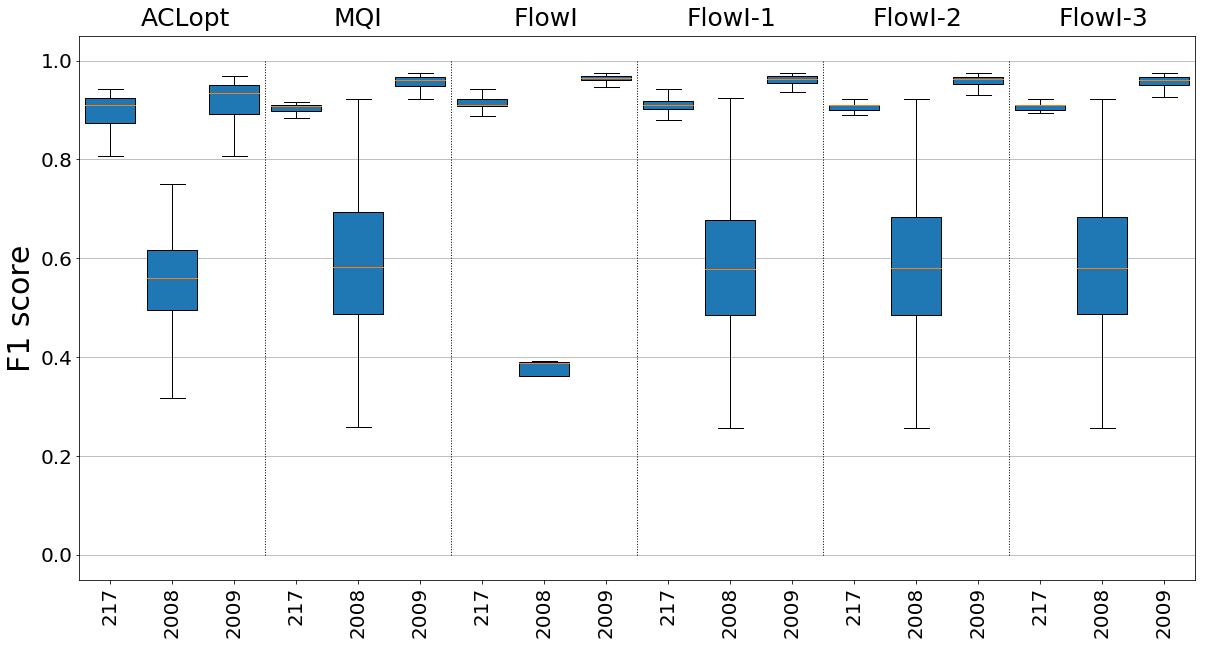

In [51]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_pre_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Villanova62_f1_Optimal.png')

plt.show()

## Generate scatter plot for precision

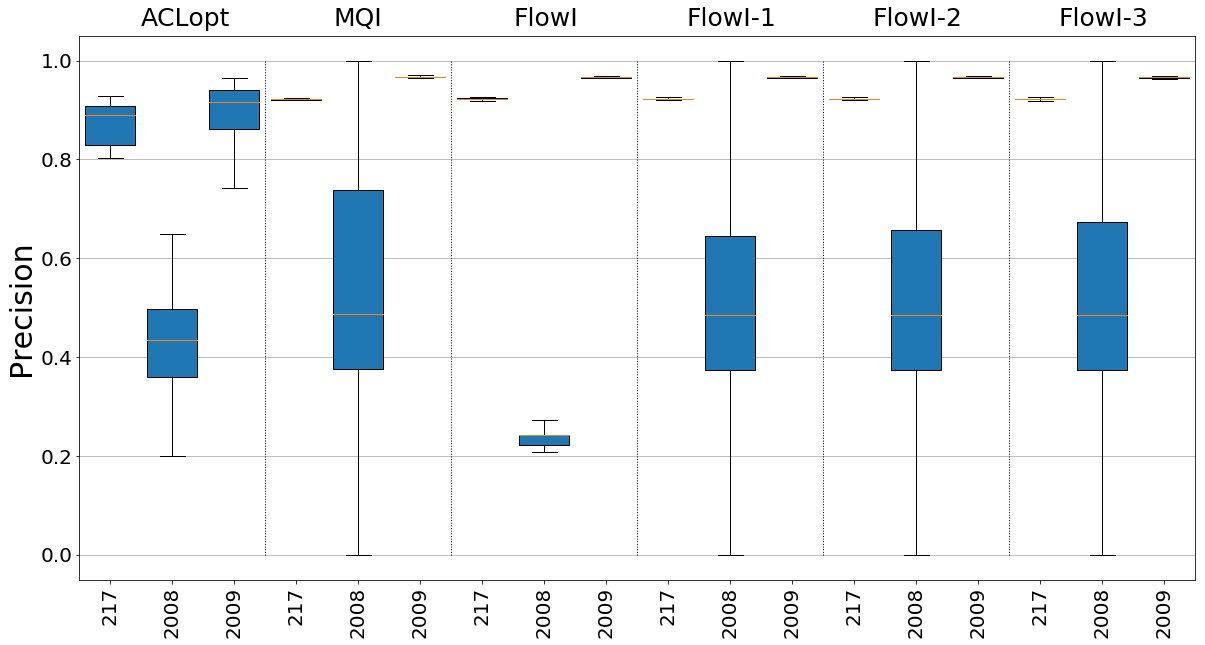

In [52]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Villanova62_precision_Optimal.png')

plt.show()

## Generate scatter plot for recall

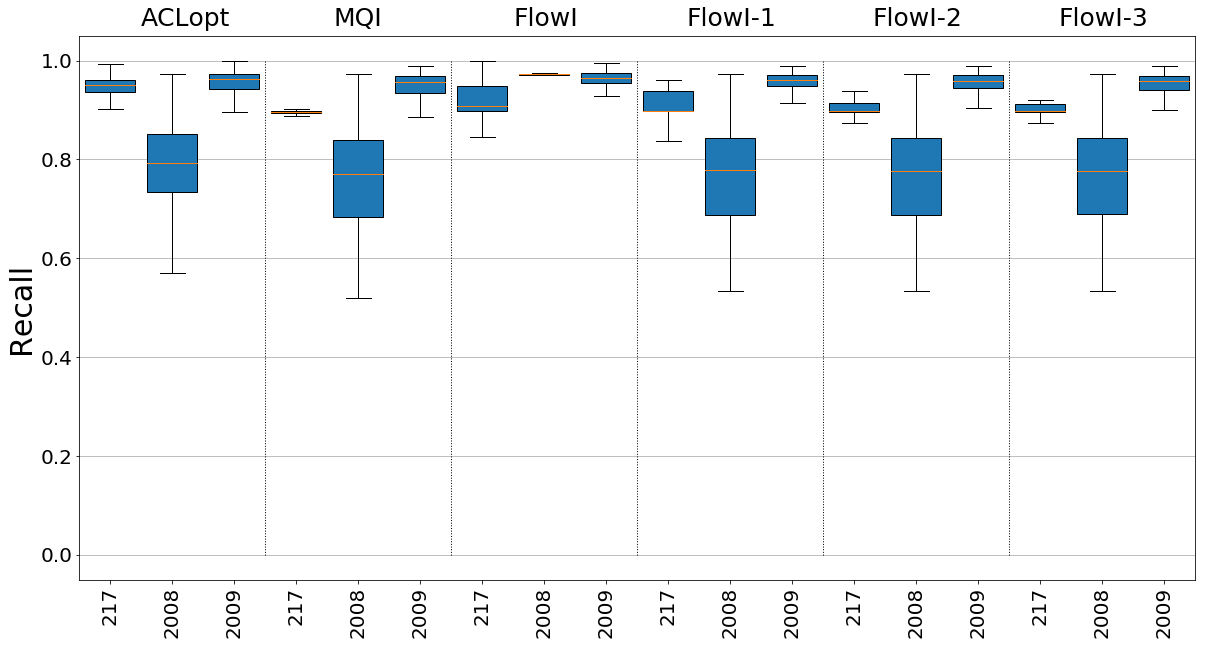

In [53]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_pre_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Villanova62_recall_Optimal.png')

plt.show()

## Generate precision/recall and F1 scores

In [54]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
        temp_rec.append(recall_best_pre_acl[i,j])
        temp_f1.append(f1score_best_pre_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 217.0 Precision 0.8897562926295137 Recall 0.949794315632012 F1 0.9107524887104499
Feature: 2008.0 Precision 0.4348970290695032 Recall 0.7927179487179488 F1 0.5602300154923237
Feature: 2009.0 Precision 0.9162806755085013 Recall 0.9621310162075553 F1 0.9340288068282853
Results for MQI
Feature: 217.0 Precision 0.9217324498223375 Recall 0.8965968586387434 F1 0.9089099526066351
Feature: 2008.0 Precision 0.4878978099577491 Recall 0.7703046757164405 F1 0.582756927168673
Feature: 2009.0 Precision 0.9670147573786894 Recall 0.955999260491773 F1 0.960659248568369
Results for FlowI
Feature: 217.0 Precision 0.9217324498223375 Recall 0.9077225130890052 F1 0.9093751480411199
Feature: 2008.0 Precision 0.2427558736164065 Recall 0.9723076923076923 F1 0.388521667496029
Feature: 2009.0 Precision 0.9663321255651394 Recall 0.9650274234300856 F1 0.9648719885321454
Results for FlowI-1
Feature: 217.0 Precision 0.9217324498223375 Recall 0.8973448017950636 F1 0.9093751480411199
Featur